In [19]:
from __future__ import division
import imp
import uproot
import matplotlib
#matplotlib.use('agg')
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
import os
import ROOT
import time
import math
from array import array
import collections

inputdir = '/home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted/'
outputdir = '/home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted_improved/'+'nue_check_2/' 
output_filedir = outputdir
lib_function_dir = '/home/tmettler/Desktop/uBoone/do_plots/'

# helper functions
globale = imp.load_source('globale',lib_function_dir+'globale.py')
NuCC = imp.load_source('NuCC_function',lib_function_dir+'NuCC_function.py')
NuCC_w = imp.load_source('NuCCWeight_function',lib_function_dir+'NuCCWeight_function.py')

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


In [20]:
# initialte ROOT default canvas
ROOT.gROOT.SetBatch(ROOT.kTRUE)
ROOT.gStyle.SetOptStat(0)
ROOT.gStyle.SetOptTitle(0)
c1 = ROOT.TCanvas("c1","c1",1600,1200)
c1.SetGrid(1)
c1.SetLeftMargin(0.14)
c1.SetRightMargin(0.05)
c1.SetBottomMargin(0.14)

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


In [21]:
def draw_adding():
    prelim = ROOT.TLatex(0.9,0.93, "MicroBooNE Preliminary");
    prelim.SetTextFont(62);
    prelim.SetTextColor(ROOT.kGray+2);
    prelim.SetNDC();
    prelim.SetTextSize(1/25.);
    prelim.SetTextAlign(32);
    #prelim.SetTextSize(0.04631579);
    prelim.Draw()

    pot_latex = ROOT.TLatex(.10, .92,'Accumulated POT: '+str(pot_data)) 
    pot_latex.SetTextFont(62);
    pot_latex.SetTextColor(ROOT.kGray+2);
    pot_latex.SetNDC();
    pot_latex.SetTextSize(1/25.);
    pot_latex.SetTextAlign(10) #;//left adjusted
    pot_latex.Draw();
    
    return prelim, pot_latex

def draw_sim():
    prelim = ROOT.TLatex(0.9,0.93, "MicroBooNE Simulation Preliminary");
    prelim.SetTextFont(62);
    prelim.SetTextColor(ROOT.kGray+2);
    prelim.SetNDC();
    prelim.SetTextSize(1/20.);
    prelim.SetTextAlign(32);
    #prelim.SetTextSize(0.04631579);
    prelim.Draw()
    
    return prelim

# Nue cross check
The filter must pass fewer than 45 electron neutrino events normalized to 6.6E20 POT
counted within a range of true neutrino energy between 50 MeV to 1.5 GeV using a
sample of ~300,000 cosmic-overlaid charged current electron neutrino interactions in the
TPC

In [22]:
# Load input files
#inputdir = '/home/thomasm/numuCC/V33/10kevents/'
outputdir_png, outputdir_root,outputdir_pdf = NuCC.prepareOutput2(outputdir)
try:
    os.stat(output_filedir)
except:
    os.mkdir(output_filedir)
RootFile = ROOT.TFile(output_filedir+"nue_check_2.root","RECREATE");
filename_overlay = 'NuCCana_overlay_V26_mar18.root'
filename_ext = 'NuCCana_ext_V25.root'

tree_name = 'numuCCAna'

overlay = ROOT.TChain(tree_name + "/event","event")
overlay.Add( inputdir + filename_overlay)

ext = ROOT.TChain(tree_name + "/event","event")
ext.Add( inputdir + filename_ext)

pot_overlay = NuCC.getPOT(inputdir,filename_overlay,tree_name)
print 'POT: ',pot_overlay

pot_data =    7.644e+18  # best with tor875
data_trigger = 1838700.0 #2220362.0 #1854495.0 #4743794 # 1987072.0 # E1DCNT_wcut
ext_trigger =  18997529.0  #2120135 #5685315 # EXT


pot_run3G1 = 2.1e20
scale = pot_run3G1/pot_overlay
scale_ext = (pot_run3G1/pot_data)*(data_trigger/ext_trigger)
print scale, scale_ext
#print pot_run3G1/pot_data

POT:  1.26811760704e+21
0.165599782571 2.65896350329


In [23]:
filename_overlay = 'NuCCana_overlay_V26_mar18_noflux.rootout4.root'
tree_name = 't_out'

overlay_out = ROOT.TChain(tree_name, "t_out")
overlay_out.Add( inputdir + filename_overlay)

print 'Entries TTree: ',overlay.GetEntries()
print 'Entries Tout: ',overlay_out.GetEntries()

Entries TTree:  1012051
Entries Tout:  1013969


In [24]:
offset = 0
fidVol = '(Nu_Vx_sce>(-1.55) && Nu_Vx_sce<(254.8)) && (Nu_Vy_sce>(-115.53) && Nu_Vy_sce<(117.47)) &&(Nu_Vz_sce>(-0.1) && Nu_Vz_sce<(1036.9))'
MCfidVol = '(MCNu_Vx>(-1.55) && MCNu_Vx<(254.8)) && (MCNu_Vy>(-115.53) && MCNu_Vy<(117.47)) &&(MCNu_Vz>(-0.1) && MCNu_Vz<(1036.9))'
numu_signal = 'fidVol && MCfidVol && MCNu_CCNC==0 && MCNu_PDG==14 && MCTrackPDG==13 && MCTrackPurity>0.5' # numu CC signal definition
numu_true = 'MCfidVol && MCNu_CCNC==0 && MCNu_PDG==14' # numu CC signal definition
numu_nomu = 'fidVol && MCfidVol && MCNu_CCNC==0 && MCNu_PDG==14 && MCTrackPDG!=13 && MCTrackPurity>0.5' # not an MC muon
numu_lowpur = 'fidVol && MCfidVol && MCNu_CCNC==0 && MCNu_PDG==14 && MCTrackPurity<0.5' #low purity
numu_nc = 'fidVol && MCfidVol && MCNu_CCNC==1' # nutral current
numu_ov = 'fidVol && !MCfidVol' # out of fiducial
numu_other = 'fidVol && MCfidVol && MCNu_CCNC==0 && MCNu_PDG!=14' # e.g anti nu or nue
#signal = 'MCfidVol && MCNu_CCNC==0 && MCNu_PDG==14'
sample = [overlay,overlay_out,ext]
for x in sample:
    x.SetAlias('muon','(muon_candidate_key==track_key)')
    x.SetAlias('fidVol',fidVol)
    x.SetAlias('MCfidVol',MCfidVol)
    x.SetAlias('numu_signal',numu_signal)
    x.SetAlias('numu_true',numu_true)
    x.SetAlias('numu_nomu',numu_nomu)
    x.SetAlias('numu_lowpur',numu_lowpur)
    x.SetAlias('numu_nc',numu_nc)
    x.SetAlias('numu_ov',numu_ov)
    x.SetAlias('numu_other',numu_other)

In [25]:
fidVol = '(Nu_Vx_sce>(-1.55) && Nu_Vx_sce<(254.8)) && (Nu_Vy_sce>(-115.53) && Nu_Vy_sce<(117.47)) &&(Nu_Vz_sce>(-0.1) && Nu_Vz_sce<(1036.9))'

track_start_border_x = '(TrackStart_x_sce <(-1.55+5) || TrackStart_x_sce > (254.8-5))'
track_end_border_x = '(TrackEnd_x_sce <(-1.55+5) || TrackEnd_x_sce > (254.8-5))'
track_start_border_y = '(TrackStart_y_sce <(-115.53+5) || TrackStart_y_sce > (117.47-5))'
track_end_border_y = '(TrackEnd_y_sce <(-115.53+5) || TrackEnd_y_sce > (117.47-5))'
track_start_border_z = '(TrackStart_z_sce <(0.1+5) || TrackStart_z_sce > (1036.9-5))'
track_end_border_z = '(TrackEnd_z_sce <(0.1+5) || TrackEnd_z_sce > (1039.9-5))'
track_end_uncontained = '(' + track_end_border_x + ' || ' + track_end_border_y + ' || ' + track_end_border_z+ ')'

crt_tom_cut = 'nr_crthit_top==0 && crthit_vertex_zcut==0 && (track_end_uncontained==1 || nr_crthit_beam_tres==0) && crt_cut'

sample = [overlay,overlay_out,ext]
for x in sample:
    x.SetAlias('fidVol',fidVol)
    x.SetAlias('muon','(track_key == key_muon)')
    x.SetAlias("track_end_uncontained",track_end_uncontained)
    x.SetAlias("crt_cut","(abs(crtt0_time-3.95)<0.9 || crtt0_time==-1)")
    x.SetAlias("crt_tom_cut",crt_tom_cut)
    
weight_name = 'EventWeight*TunedCentralValue_Genie'


In [91]:
cut = 'fidVol && muon && TrackLength>8 && crt_tom_cut && TrackScore>0.8\
                && TrackLength>20 && TrackPID_chiproton>78 && NuScore>0.1'
this_cut = ' && MCNu_PDG==12 && MCNu_Energy<1.5 && MCNu_Energy>0.05 && MCTrackPurity>0.5 && MCTrackPDG==11'
#nue_pass_rate = overlay.GetEntries(cut+this_cut)
#print 'Nues passing cut: ', nue_pass_rate

nue_tot_rate0 = overlay_out.GetEntries('MCNu_PDG==12 && MCNu_Energy<1.5 && MCNu_Energy>0.05')*scale
print 'Nues (tot): ', nue_tot_rate0

nue_tot_rate0 = overlay.GetEntries('MCNu_PDG==12 && MCNu_Energy<1.5 && MCNu_Energy>0.05')*scale
print 'Nues (tot): ', nue_tot_rate0

nue_tot_rate0 = overlay.GetEntries('MCNu_PDG==12 && MCNu_Energy<1.5 && MCNu_Energy>0.05 && MCNu_CCNC==0')*scale
print 'Nues (CC tot): ', nue_tot_rate0

nue_tot_rate1 = overlay.GetEntries('MCNu_PDG==12 && MCNu_Energy<1.5 && MCNu_Energy>0.05 && MCfidVol && MCNu_CCNC==0')*scale
print 'Nues (tot in fidVol): ', nue_tot_rate1, '={:04.2f} %'.format((nue_tot_rate1*100.0)/nue_tot_rate0)

nue_tot_rate2 = overlay.GetEntries('MCNu_PDG==12 && MCNu_Energy<1.5 && MCNu_Energy>0.05 && MCfidVol && MCle_PDG==11')*scale
print 'electrons (tot in fidVol): ', nue_tot_rate2, '={:04.2f} %'.format((nue_tot_rate2*100.0)/nue_tot_rate1)

nue_tot_rate3 = overlay.GetEntries('MCNu_PDG==12 && MCNu_Energy<1.5 && MCNu_Energy>0.05 && MCfidVol && MCle_PDG==11 && \
                        MCTrackPDG==11 && sqrt(pow(MCle_Endx-MCTrackEnd_x,2)+pow(MCle_Endy-MCTrackEnd_y,2))<0.1')*scale
print 'matched electrons (tot in fidVol): ', nue_tot_rate3, '={:04.2f} %'.format((nue_tot_rate3*100.0)/nue_tot_rate1)


nue_tot_rate4 = overlay.GetEntries('MCNu_PDG==12 && MCNu_Energy<1.5 && MCNu_Energy>0.05 && MCfidVol && MCle_PDG==11 && \
                        MCTrackPDG==11 && sqrt(pow(MCle_Endx-MCTrackEnd_x,2)+pow(MCle_Endy-MCTrackEnd_y,2))<0.1 &&\
                        MCTrackPurity>0.5')*scale
print 'matched electrons (tot in fidVol, purity>0.5): ', nue_tot_rate4, '={:04.2f} %'.format((nue_tot_rate4*100.0)/nue_tot_rate1)

nue_tot_rate5 = overlay.GetEntries('fidVol && MCNu_PDG==12 && MCNu_Energy<1.5 && MCNu_Energy>0.05 && MCfidVol && MCle_PDG==11 && \
                        MCTrackPDG==11 && sqrt(pow(MCle_Endx-MCTrackEnd_x,2)+pow(MCle_Endy-MCTrackEnd_y,2))<0.1 &&\
                        MCTrackPurity>0.5')*scale
print 'matched electrons (tot in fidVol, reco in fidVol, purity>0.5): ', nue_tot_rate5, '={:04.2f} %'.format((nue_tot_rate5*100.0)/nue_tot_rate1)

nue_tot_rate6 = overlay.GetEntries('fidVol && MCNu_PDG==12 && MCNu_Energy<1.5 && MCNu_Energy>0.05 && MCfidVol && MCle_PDG==11 && \
                        MCTrackPDG==11 && sqrt(pow(MCle_Endx-MCTrackEnd_x,2)+pow(MCle_Endy-MCTrackEnd_y,2))<0.1 &&\
                        MCTrackPurity>0.5 && NuShowers==0')*scale
print 'matched electrons (tot in fidVol, reco in fidVol, purity>0.5): ', nue_tot_rate6, '={:04.2f} %'.format((nue_tot_rate6*100.0)/nue_tot_rate1)


Nues (tot):  570.325651176
Nues (tot):  569.33205248
Nues (CC tot):  412.17785882
Nues (tot in fidVol):  175.701369308 =42.63 %
electrons (tot in fidVol):  175.701369308 =100.00 %
matched electrons (tot in fidVol):  13.4135823883 =7.63 %
matched electrons (tot in fidVol, purity>0.5):  9.10798804142 =5.18 %
matched electrons (tot in fidVol, reco in fidVol, purity>0.5):  9.10798804142 =5.18 %
matched electrons (tot in fidVol, reco in fidVol, purity>0.5):  0.0 =0.00 %


In [62]:

nue_tot_rate1 = overlay.GetEntries('MCNu_CCNC==1 && MCNu_Interaction==1 && MCle_PDG[1]==22')*scale
print 'Delta NC (tot): ', nue_tot_rate1

nue_tot_rate2 = overlay.GetEntries('MCNu_CCNC==1 && MCNu_Interaction==1 && MCle_PDG[1]==22 && fidVol')*scale
print 'Delta NC (tot in fidVol, reco fidVol): ', nue_tot_rate2, '={:04.2f} %'.format((nue_tot_rate2*100.0)/nue_tot_rate1)

cut = 'MCNu_CCNC==1 && MCNu_Interaction==1 && MCle_PDG[1]==22 && fidVol && \
        sqrt( pow(TrackStart_x_sce - MCNu_Vx,2) + pow(TrackStart_y_sce - MCNu_Vy,2) + pow(TrackStart_z_sce - MCNu_Vz,2) )<15'

nue_tot_rate3 = overlay.GetEntries(cut)*scale
print 'One track <15cm: ', nue_tot_rate3, '={:04.2f} %'.format((nue_tot_rate3*100.0)/nue_tot_rate1)


nue_tot_rate4 = overlay.GetEntries(cut+' && MCTrackPurity>0.5 && sqrt( pow(TrackStart_x_sce - MCTrackStart_x,2) + \
    pow(TrackStart_y_sce - MCTrackStart_y,2) + pow(TrackStart_z_sce - MCTrackStart_z,2) )<15')*scale
print 'one track < 15cm + high purity: ', nue_tot_rate4, '={:04.2f} %'.format((nue_tot_rate4*100.0)/nue_tot_rate1)

nue_tot_rate4 = overlay.GetEntries(cut+' && MCTrackPurity>0.5 && sqrt( pow(TrackStart_x_sce - MCTrackStart_x,2) + \
    pow(TrackStart_y_sce - MCTrackStart_y,2) + pow(TrackStart_z_sce - MCTrackStart_z,2) )<15 && NuShowers==0')*scale
print 'one track < 15cm + high purity, 0 shower: ', nue_tot_rate4, '={:04.2f} %'.format((nue_tot_rate4*100.0)/nue_tot_rate1)


Delta NC (tot):  190.60534974
Delta NC (tot in fidVol, reco fidVol):  85.1182882417 =44.66 %
One track <15cm:  29.1455617326 =15.29 %
one track < 15cm + high purity:  25.8335660811 =13.55 %
one track < 15cm + high purity, 0 shower:  0.0 =0.00 %


In [27]:
tot_events = overlay.GetEntries('fidVol')*scale + ext.GetEntries('fidVol')*scale_ext
print 'Tot events (overlay+ext in fidVol(reco)): ', tot_events
tot_no_shower = overlay.GetEntries('fidVol && NuShowers==0')*scale + ext.GetEntries('fidVol && NuShowers==0')*scale_ext
print 'Tot events w 0 shower(overlay+ext in fidVol(reco)): ', tot_no_shower, tot_no_shower/tot_events


Tot events (overlay+ext in fidVol(reco)):  145760.557349
Tot events w 0 shower(overlay+ext in fidVol(reco)):  2708.68936284 0.0185831435616


Warning in <TFile::Append>: Replacing existing TH1: h_temp (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: h_temp1 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: h_temp2 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: h_temp3 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: h_temp4 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: h_temp5 (Potential memory leak).
Info in <TCanvas::Print>: png file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted_improved/nue_check_2/png/h_num_tracks.png has been created
Info in <TCanvas::Print>: pdf file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted_improved/nue_check_2/pdf/h_num_tracks.pdf has been created


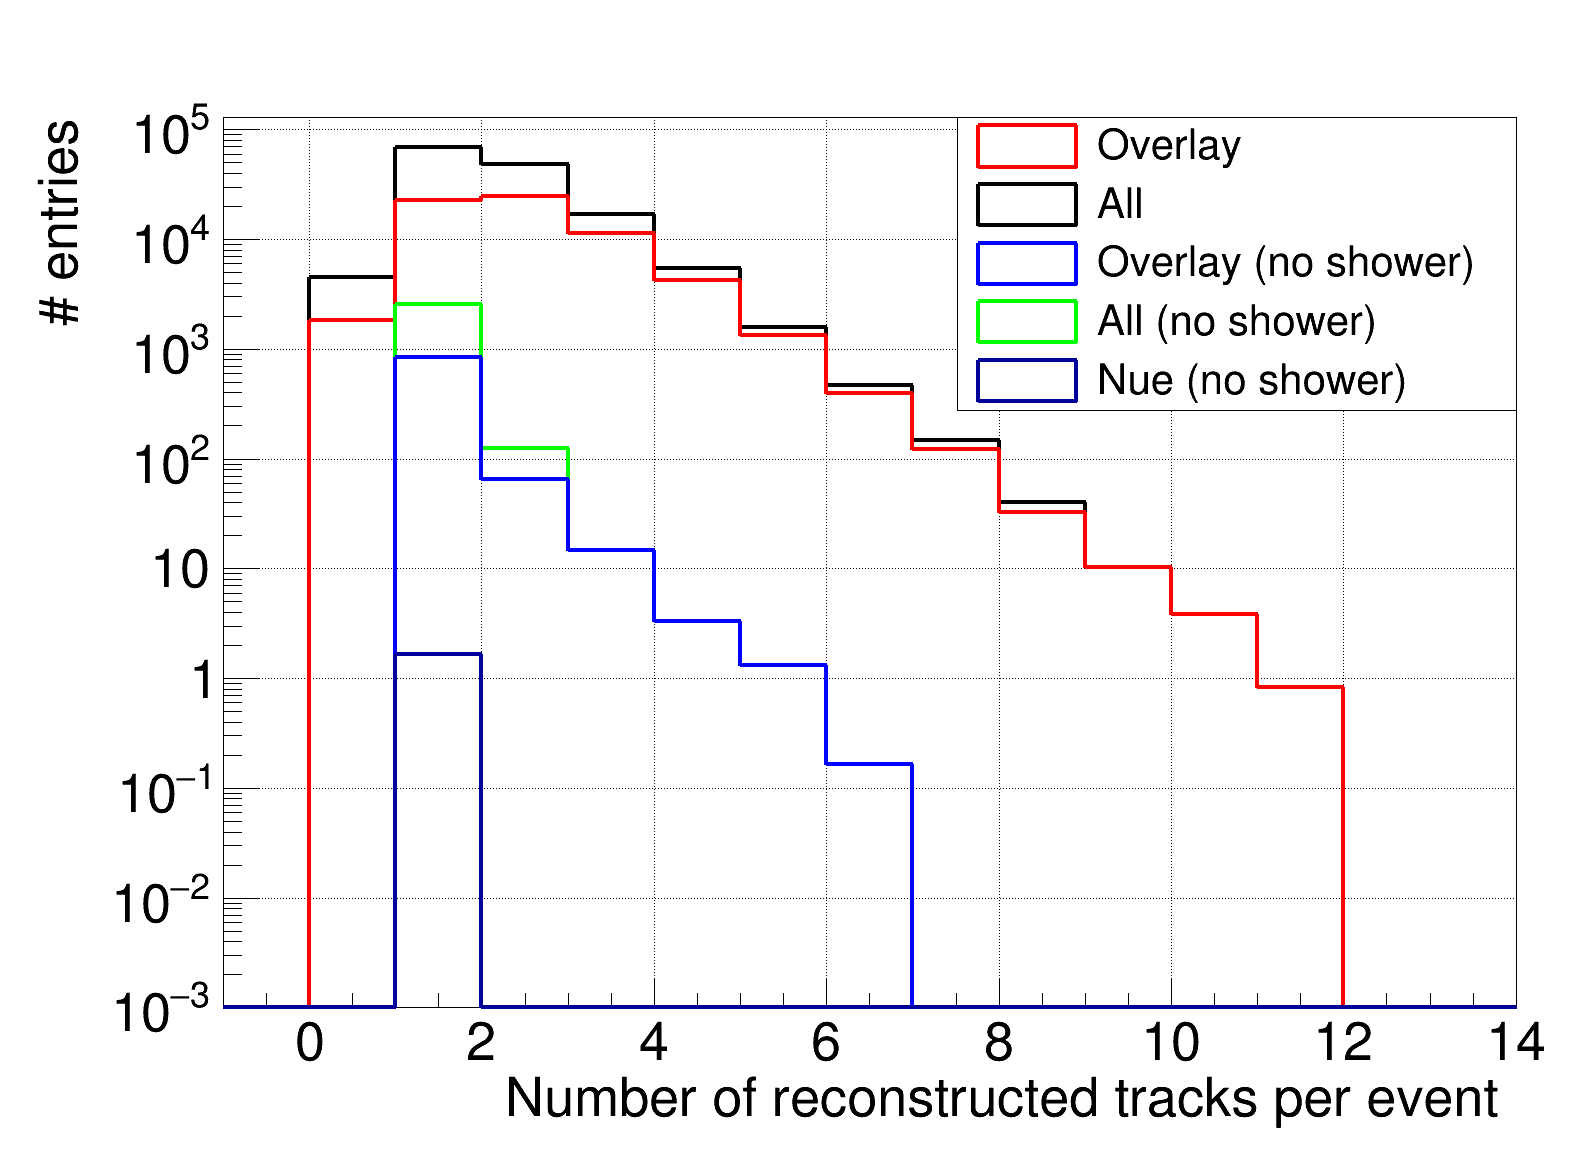

In [93]:
h_temp = ROOT.TH1F("h_temp",'h_temp',15,-1,14)
h_temp1 = ROOT.TH1F("h_temp1",'h_temp1',15,-1,14)

h_temp2 = ROOT.TH1F("h_temp2",'h_temp',15,-1,14)
h_temp3 = ROOT.TH1F("h_temp3",'h_temp1',15,-1,14)

h_temp4 = ROOT.TH1F("h_temp4",'h_temp4',15,-1,14)
h_temp5 = ROOT.TH1F("h_temp5",'h_temp5',15,-1,14)

ROOT.gStyle.SetPaintTextFormat("0.0f");


overlay.Draw('NuTracks'+'>>h_temp','fidVol','')
ext.Draw('NuTracks'+'>>h_temp1','fidVol','')

h_temp.Scale(scale)
h_temp1.Scale(scale_ext)

h_temp1.Add(h_temp)


overlay.Draw('NuTracks'+'>>h_temp2','fidVol && NuShowers==0','')
ext.Draw('NuTracks'+'>>h_temp3','fidVol && NuShowers==0','')

h_temp2.Scale(scale)
h_temp3.Scale(scale_ext)

h_temp3.Add(h_temp2)

overlay.Draw('NuTracks'+'>>h_temp4','fidVol && NuShowers==0 && MCNu_PDG==12','')
#ext.Draw('NuTracks'+'>>h_temp5','fidVol && NuShowers==0 && MCNu_PDG==12','')

h_temp4.Scale(scale)
#h_temp5.Scale(scale_ext)

#h_temp5.Add(h_temp4)

h_temp1.SetLineColor(ROOT.kBlack)
h_temp.SetLineColor(ROOT.kRed)
h_temp2.SetLineColor(ROOT.kBlue)
h_temp3.SetLineColor(ROOT.kGreen)
h_temp.SetLineWidth(4)
h_temp1.SetLineWidth(4)
h_temp2.SetLineWidth(4)
h_temp3.SetLineWidth(4)
h_temp4.SetLineWidth(4)
#h_temp5.SetLineWidth(4)

legend = ROOT.TLegend(0.6,0.65,0.95,0.9)
legend.AddEntry(h_temp,'Overlay',"f")
legend.AddEntry(h_temp1,'All',"f")
legend.AddEntry(h_temp2,'Overlay (no shower)',"f")
legend.AddEntry(h_temp3,'All (no shower)',"f")
legend.AddEntry(h_temp4,'Nue (no shower)',"f")
#legend.AddEntry(h_temp5,'all',"f")

h_temp1.SetXTitle("Number of reconstructed tracks per event")
h_temp1.SetYTitle("# entries")
h_temp1.GetYaxis().SetTitleSize(0.05)
h_temp1.GetYaxis().SetTitleOffset(1.3)
h_temp1.GetYaxis().SetLabelSize(0.05)
h_temp1.GetXaxis().SetTitleSize(0.05)
h_temp1.GetXaxis().SetLabelSize(0.05)
h_temp1.GetXaxis().SetTitleOffset(1)

h_temp1.SetMinimum(0.001)
h_temp1.Draw('hist')
h_temp.Draw('same hist')

h_temp3.Draw('same hist')
h_temp2.Draw('same hist')

#h_temp5.Draw('same hist')
h_temp4.Draw('same hist')
legend.Draw()


c1.SetLogy(1)
c1.Draw()
c1.SaveAs(outputdir_png + 'h_num_tracks.png')
#c1.SaveAs(outputdir_root + 'h_xsec_2D_'+str(x_theta)+'.root')
c1.SaveAs(outputdir_pdf + 'h_num_tracks.pdf')

Warning in <TFile::Append>: Replacing existing TH1: h_temp (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: h_temp1 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: h_temp2 (Potential memory leak).


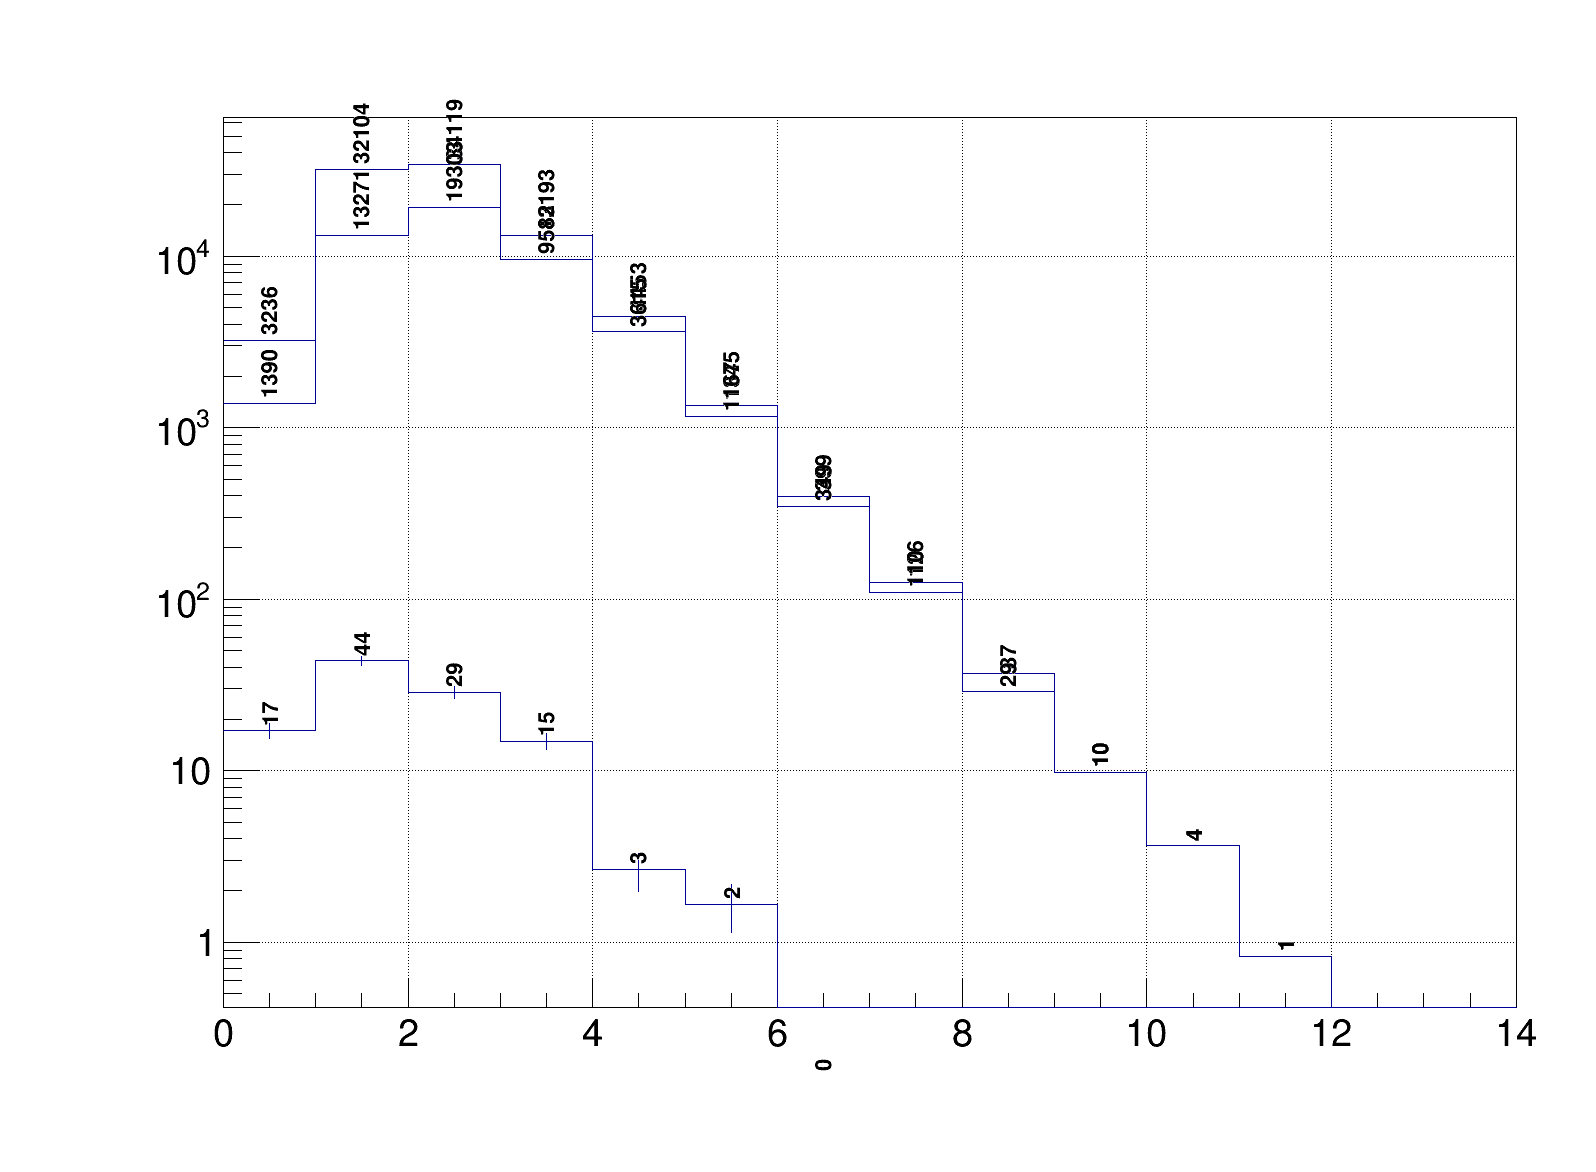

In [13]:
h_temp = ROOT.TH1F("h_temp",'h_temp',14,0,14)
h_temp1 = ROOT.TH1F("h_temp1",'h_temp1',14,0,14)
h_temp2 = ROOT.TH1F("h_temp2",'h_temp2',14,0,14)

ROOT.gStyle.SetPaintTextFormat("0.0f");


overlay.Draw('NuTracks'+'>>h_temp','fidVol','')
overlay.Draw('NuTracks'+'>>h_temp2','fidVol && MCNu_PDG==12 && MCNu_Energy<1.5 && MCNu_Energy>0.05 && MCfidVol && MCNu_CCNC==0','')

ext.Draw('NuTracks'+'>>h_temp1','fidVol','')

h_temp.Scale(scale)
h_temp2.Scale(scale)
h_temp1.Scale(scale_ext)

h_temp1.Add(h_temp)

h_temp1.Draw('hist text')
h_temp.Draw('same hist text')
h_temp2.Draw('same hit text')

c1.Draw()

43634.0
tot tracks (ov+ext):  249220.736215
tot tracks (ov):  133199.522712
tot tracks (nue):  202.19733452
tot tracks (nue_matched):  9.10798804142


Warning in <TFile::Append>: Replacing existing TH1: h_temp (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: h_temp1 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: h_temp2 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: h_temp3 (Potential memory leak).
Info in <TCanvas::Print>: png file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted_improved/nue_check_2/png/h_tracklength.png has been created
Info in <TCanvas::Print>: pdf file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted_improved/nue_check_2/pdf/h_tracklength.pdf has been created


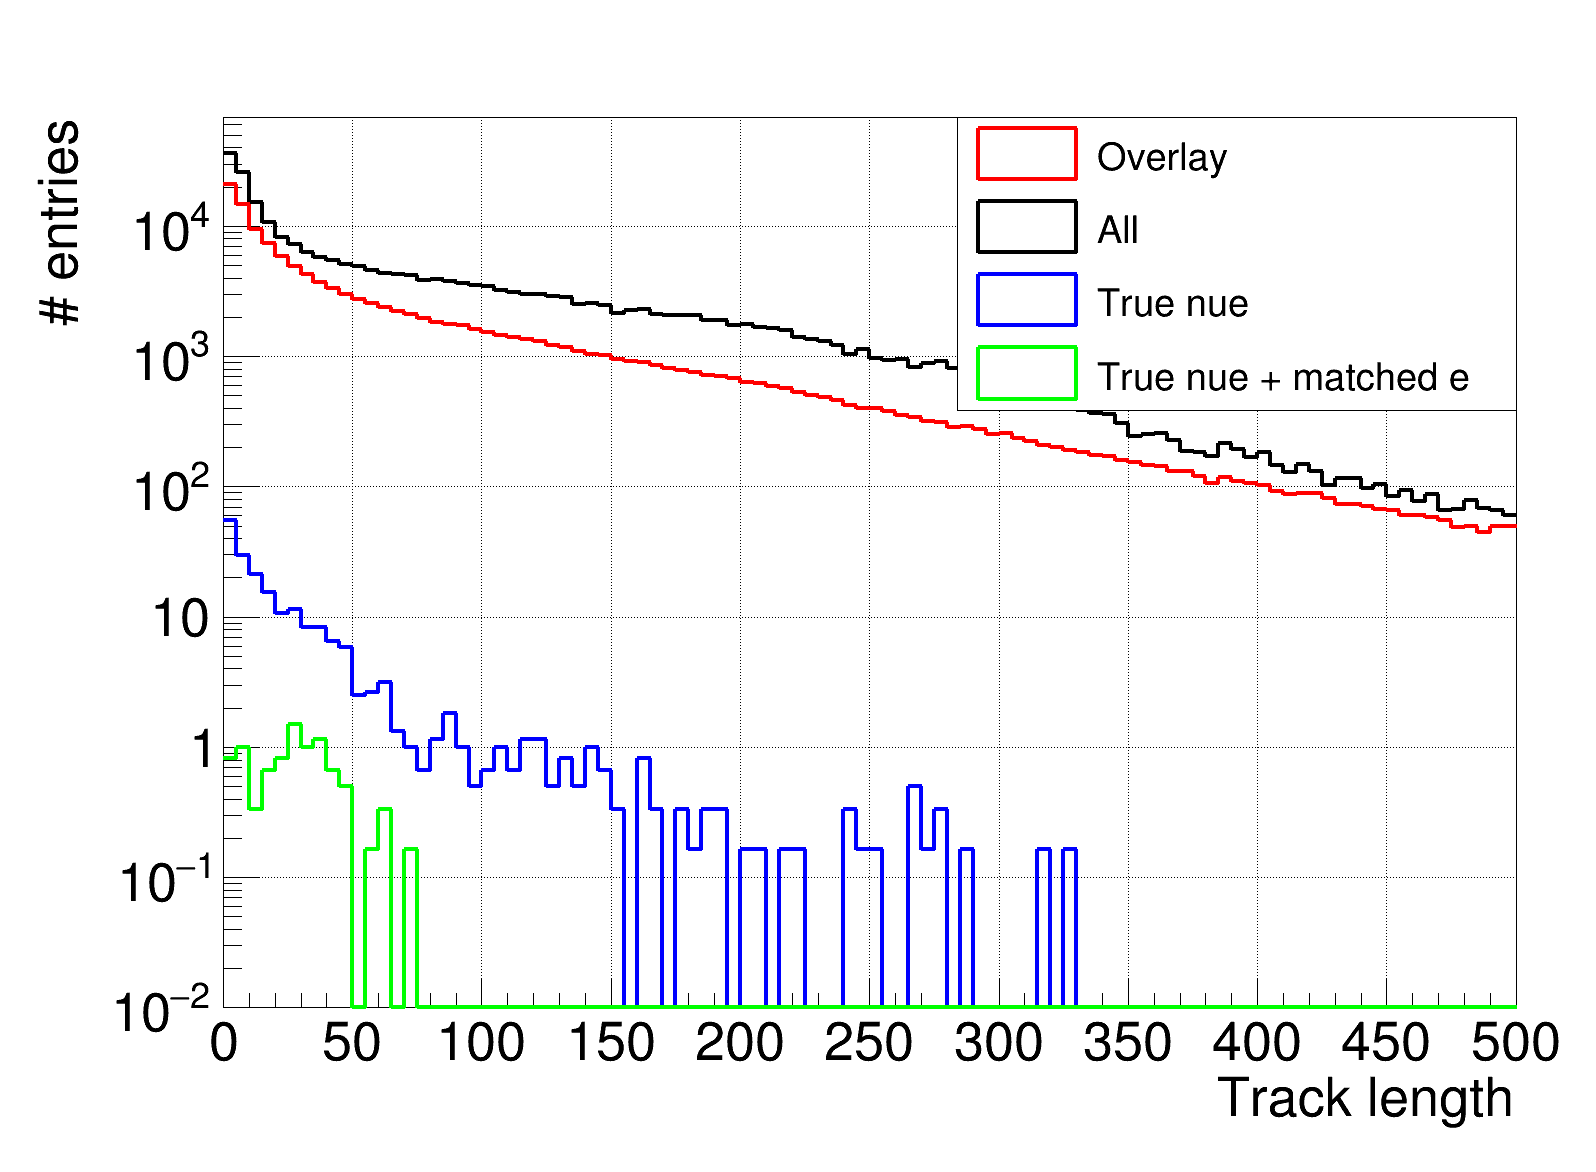

In [94]:
h_temp = ROOT.TH1F("h_temp",'h_temp',100,0,500)
h_temp1 = ROOT.TH1F("h_temp1",'h_temp1',100,0,500)
h_temp2 = ROOT.TH1F("h_temp2",'h_temp2',100,0,500)
h_temp3 = ROOT.TH1F("h_temp3",'h_temp3',100,0,500)

ROOT.gStyle.SetPaintTextFormat("0.1f");


overlay.Draw('TrackLength'+'>>h_temp','fidVol','')
overlay.Draw('TrackLength'+'>>h_temp2','fidVol && MCNu_PDG==12 && MCNu_Energy<1.5 && MCNu_Energy>0.05 && MCfidVol && MCNu_CCNC==0','')
overlay.Draw('TrackLength'+'>>h_temp3','fidVol && MCNu_PDG==12 && MCNu_Energy<1.5 && MCNu_Energy>0.05 && MCfidVol && MCle_PDG==11 && \
                        MCTrackPDG==11 && sqrt(pow(MCle_Endx-MCTrackEnd_x,2)+pow(MCle_Endy-MCTrackEnd_y,2))<0.1 &&\
                        MCTrackPurity>0.5')*scale

ext.Draw('TrackLength'+'>>h_temp1','fidVol','')

h_temp.Scale(scale)
h_temp2.Scale(scale)
h_temp3.Scale(scale)
h_temp1.Scale(scale_ext)
num_track_tot = h_temp1.GetEntries()
print num_track_tot

h_temp1.Add(h_temp)

num_track_tot_ov = h_temp.GetEntries()
num_track_tot_nue = h_temp2.GetEntries()
num_track_tot_nue_m = h_temp3.GetEntries()

print 'tot tracks (ov+ext): ',num_track_tot*scale_ext + num_track_tot_ov*scale
print 'tot tracks (ov): ',num_track_tot_ov*scale
print 'tot tracks (nue): ',num_track_tot_nue*scale
print 'tot tracks (nue_matched): ',num_track_tot_nue_m*scale

h_temp1.SetLineColor(ROOT.kBlack)
h_temp.SetLineColor(ROOT.kRed)
h_temp2.SetLineColor(ROOT.kBlue)
h_temp3.SetLineColor(ROOT.kGreen)
h_temp.SetLineWidth(4)
h_temp1.SetLineWidth(4)
h_temp2.SetLineWidth(4)
h_temp3.SetLineWidth(4)
#h_temp4.SetLineWidth(4)
#h_temp5.SetLineWidth(4)

legend = ROOT.TLegend(0.6,0.65,0.95,0.9)
legend.AddEntry(h_temp,'Overlay',"f")
legend.AddEntry(h_temp1,'All',"f")
legend.AddEntry(h_temp2,'True nue',"f")
legend.AddEntry(h_temp3,'True nue + matched e',"f")
#legend.AddEntry(h_temp4,'Overlay (+matched e)',"f")
#legend.AddEntry(h_temp5,'all',"f")

h_temp1.SetXTitle("Track length")
h_temp1.SetYTitle("# entries")
h_temp1.GetYaxis().SetTitleSize(0.05)
h_temp1.GetYaxis().SetTitleOffset(1.3)
h_temp1.GetYaxis().SetLabelSize(0.05)
h_temp1.GetXaxis().SetTitleSize(0.05)
h_temp1.GetXaxis().SetLabelSize(0.05)
h_temp1.GetXaxis().SetTitleOffset(1)

h_temp1.SetMinimum(0.01)
h_temp1.Draw('hist')
h_temp.Draw('same hist')
h_temp2.Draw('same hist')
h_temp3.Draw('same hist')
legend.Draw()
c1.SetLogy(1)
c1.Draw()
c1.SaveAs(outputdir_png + 'h_tracklength.png')
#c1.SaveAs(outputdir_root + 'h_xsec_2D_'+str(x_theta)+'.root')
c1.SaveAs(outputdir_pdf + 'h_tracklength.pdf')

24076.0
tot tracks (ov+ext):  168159.430969
tot tracks (ov+ext+2*NC):  181768.421101


Warning in <TFile::Append>: Replacing existing TH1: h_temp (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: h_temp1 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: h_temp2 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: h_temp3 (Potential memory leak).
Info in <TCanvas::Print>: png file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted_improved/nue_check_2/png/h_tracklength.png has been created
Info in <TCanvas::Print>: pdf file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted_improved/nue_check_2/pdf/h_tracklength.pdf has been created


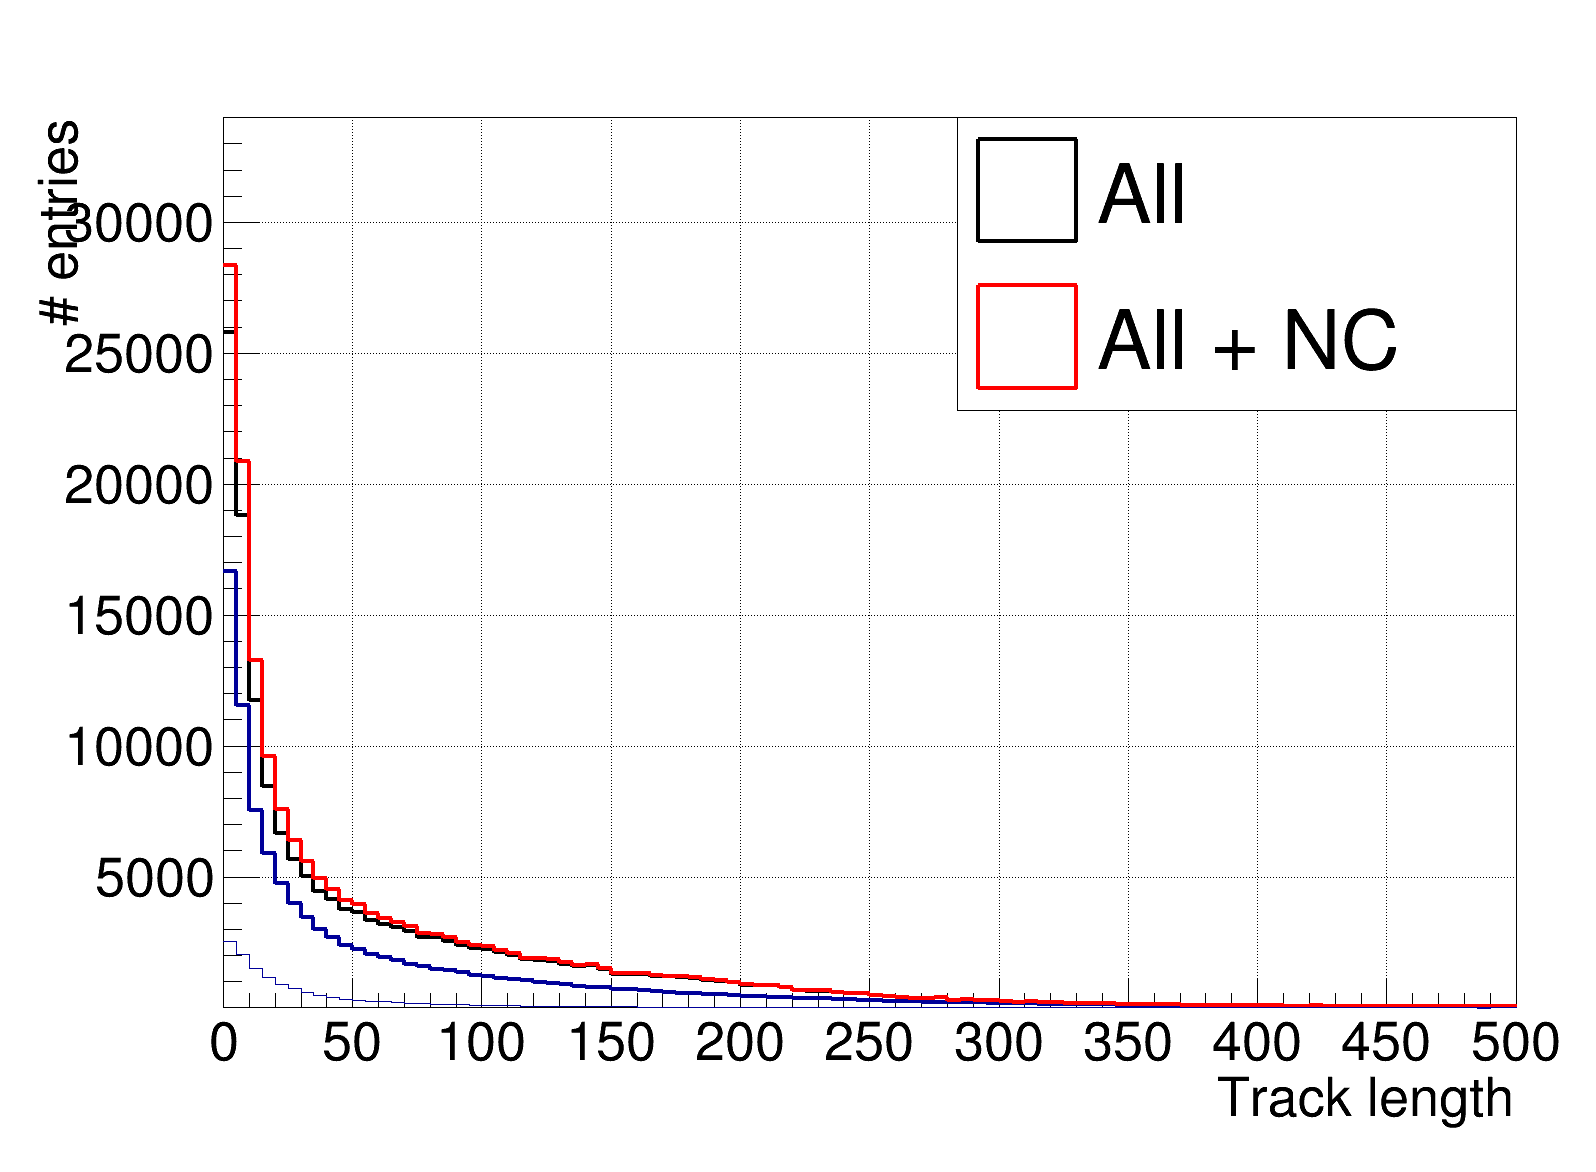

In [15]:
h_temp = ROOT.TH1F("h_temp",'h_temp',100,0,500)
h_temp1 = ROOT.TH1F("h_temp1",'h_temp1',100,0,500)
h_temp2 = ROOT.TH1F("h_temp2",'h_temp2',100,0,500)
h_temp3 = ROOT.TH1F("h_temp3",'h_temp3',100,0,500)

ROOT.gStyle.SetPaintTextFormat("0.1f");


overlay.Draw('TrackLength'+'>>h_temp','fidVol','')
overlay.Draw('TrackLength'+'>>h_temp2','fidVol && MCNu_CCNC==1','')
#overlay.Draw('TrackLength'+'>>h_temp3','fidVol && MCNu_PDG==12 && MCNu_Energy<1.5 && MCNu_Energy>0.05 && MCfidVol && MCle_PDG==11 && \
#                        MCTrackPDG==11 && sqrt(pow(MCle_Endx-MCTrackEnd_x,2)+pow(MCle_Endy-MCTrackEnd_y,2))<0.1 &&\
#                        MCTrackPurity>0.5')*scale

ext.Draw('TrackLength'+'>>h_temp1','fidVol','')

h_temp.Scale(scale)
h_temp2.Scale(scale)
#h_temp3.Scale(scale)
h_temp1.Scale(scale_ext)
num_track_tot = h_temp1.GetEntries()
print num_track_tot

h_temp1.Add(h_temp)

num_track_tot_ov = h_temp.GetEntries()
num_track_tot_nc = h_temp2.GetEntries()
#num_track_tot_nue_m = h_temp3.GetEntries()
h_temp3 = h_temp2.Clone()
h_temp2.Add(h_temp1)

print 'tot tracks (ov+ext): ',num_track_tot*scale_ext + num_track_tot_ov*scale
print 'tot tracks (ov+ext+2*NC): ',num_track_tot*scale_ext + num_track_tot_ov*scale + num_track_tot_nc*scale

h_temp1.SetLineColor(ROOT.kBlack)
#h_temp.SetLineColor(ROOT.kRed)
h_temp2.SetLineColor(ROOT.kRed)
#h_temp3.SetLineColor(ROOT.kGreen)
h_temp.SetLineWidth(4)
h_temp1.SetLineWidth(4)
h_temp2.SetLineWidth(4)
#h_temp3.SetLineWidth(4)
#h_temp4.SetLineWidth(4)
#h_temp5.SetLineWidth(4)

legend = ROOT.TLegend(0.6,0.65,0.95,0.9)
#legend.AddEntry(h_temp,'Overlay',"f")
legend.AddEntry(h_temp1,'All',"f")
legend.AddEntry(h_temp2,'All + NC',"f")
#legend.AddEntry(h_temp3,'True nue + matched e',"f")
#legend.AddEntry(h_temp4,'Overlay (+matched e)',"f")
#legend.AddEntry(h_temp5,'all',"f")

h_temp1.SetXTitle("Track length")
h_temp1.SetYTitle("# entries")
h_temp1.GetYaxis().SetTitleSize(0.05)
h_temp1.GetYaxis().SetTitleOffset(1.3)
h_temp1.GetYaxis().SetLabelSize(0.05)
h_temp1.GetXaxis().SetTitleSize(0.05)
h_temp1.GetXaxis().SetLabelSize(0.05)
h_temp1.GetXaxis().SetTitleOffset(1)

h_temp1.SetMinimum(0.01)
h_temp1.SetMaximum(h_temp2.GetMaximum()*1.2)
h_temp1.Draw('hist')
h_temp.Draw('same hist')
h_temp2.Draw('same hist')
h_temp3.Draw('same hist')
legend.Draw()
c1.SetLogy(0)
c1.Draw()
c1.SaveAs(outputdir_png + 'h_tracklength.png')
#c1.SaveAs(outputdir_root + 'h_xsec_2D_'+str(x_theta)+'.root')
c1.SaveAs(outputdir_pdf + 'h_tracklength.pdf')

In [16]:
res = np.zeros((500))
chi2_mc =h_temp1.Chi2Test(h_temp2,"P CHI2",res)

Chi2 = 123.998022, Prob = 0.0452986, NDF = 99, igood = 0


In [72]:
overlay2 = ROOT.TChain('numuCCAna' + "/event","event")
overlay2.Add( inputdir + 'NuCCana_deltaNC_V26.root')
overlay2.SetAlias('fidVol',fidVol)
overlay2.SetAlias('MCfidVol',MCfidVol)
scale2 = 0.000412556586456

print overlay2.GetEntries()

108840


tot tracks (ov+ext):  249220.736215
tot tracks (nc):  11445.5945722
tot tracks (ov+ext+2*NC):  260666.330787


Warning in <TFile::Append>: Replacing existing TH1: h_temp (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: h_temp1 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: h_temp2 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: h_temp2 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: h_temp2 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: h_temp5 (Potential memory leak).
Info in <TCanvas::Print>: png file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted_improved/nue_check_2/png/h_tracklength_chi2.png has been created
Info in <TCanvas::Print>: pdf file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted_improved/nue_check_2/pdf/h_tracklength_chi2.pdf has been created


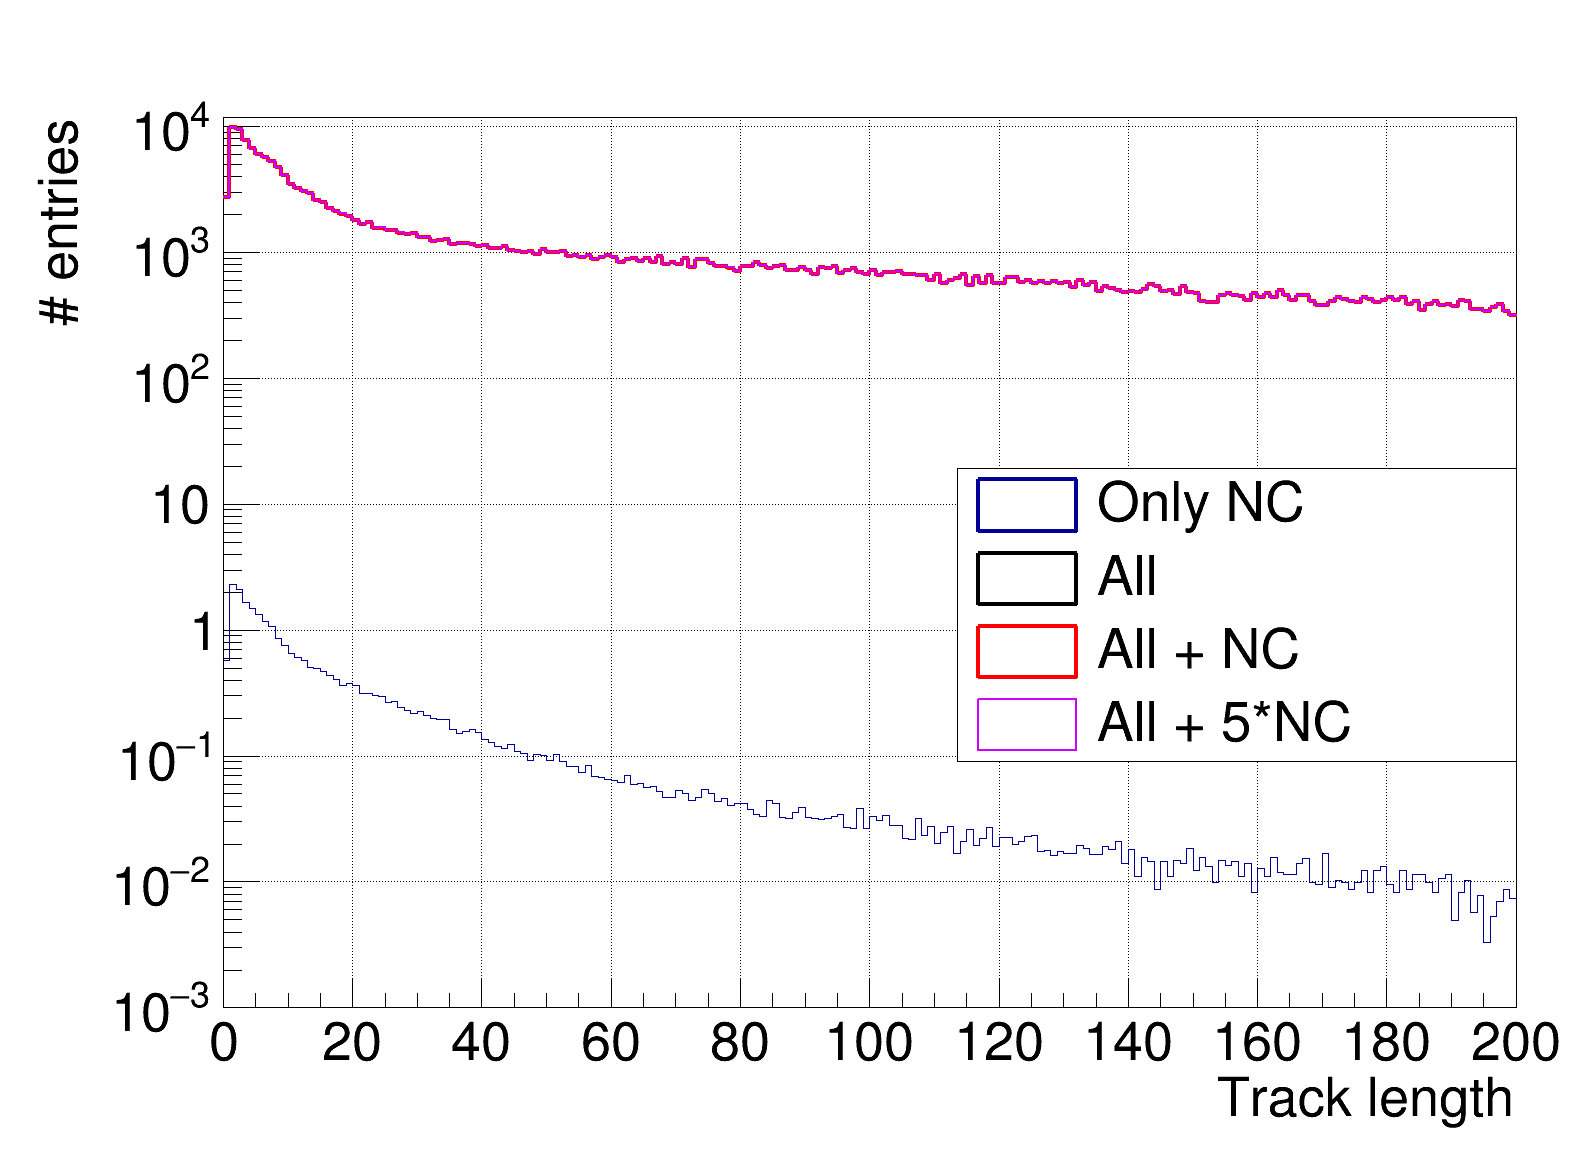

In [83]:
xmax = 200
num_bins = 200
h_temp = ROOT.TH1F("h_temp",'h_temp',num_bins,0,xmax)
h_temp1 = ROOT.TH1F("h_temp1",'h_temp1',num_bins,0,xmax)
h_temp2 = ROOT.TH1F("h_temp2",'h_temp2',num_bins,0,xmax)
h_temp3 = ROOT.TH1F("h_temp3",'h_temp3',num_bins,0,xmax)

h_temp4 = ROOT.TH1F("h_temp4",'h_temp4',num_bins,0,xmax)
h_temp5 = ROOT.TH1F("h_temp5",'h_temp5',num_bins,0,xmax)


ROOT.gStyle.SetPaintTextFormat("0.1f");


overlay.Draw('TrackLength'+'>>h_temp','fidVol','')
overlay2.Draw('TrackLength'+'>>h_temp2','fidVol && MCfidVol','')
#overlay.Draw('TrackLength'+'>>h_temp3','fidVol && MCNu_PDG==12 && MCNu_Energy<1.5 && MCNu_Energy>0.05 && MCfidVol && MCle_PDG==11 && \
#                        MCTrackPDG==11 && sqrt(pow(MCle_Endx-MCTrackEnd_x,2)+pow(MCle_Endy-MCTrackEnd_y,2))<0.1 &&\
#                        MCTrackPurity>0.5')*scale

ext.Draw('TrackLength'+'>>h_temp1','fidVol','')

h_temp.Scale(scale)
h_temp2.Scale(scale2)
#h_temp3.Scale(scale)
h_temp1.Scale(scale_ext)
num_track_tot = h_temp1.GetEntries()


h_temp1.Add(h_temp)

num_track_tot_ov = h_temp.GetEntries()
num_track_tot_nc = h_temp2.GetEntries()
#num_track_tot_nue_m = h_temp3.GetEntries()
h_temp3 = h_temp2.Clone()
h_temp2.Add(h_temp1)
#h_temp2.Add(h_temp3)

h_temp4 = h_temp2.Clone()
h_temp4.Add(h_temp3)
h_temp4.Add(h_temp3)
h_temp4.Add(h_temp3)
h_temp4.Add(h_temp3)

#h_temp5 = h_temp4.Clone()
#h_temp5.Add(h_temp3)

print 'tot tracks (ov+ext): ',num_track_tot*scale_ext + num_track_tot_ov*scale
print 'tot tracks (nc): ',num_track_tot_nc*scale
print 'tot tracks (ov+ext+2*NC): ',num_track_tot*scale_ext + num_track_tot_ov*scale + num_track_tot_nc*scale

for i in range(num_bins):
    #h_temp1.SetBinError(i+1,0)
    #h_temp2.SetBinError(i+1,0)
    h_temp1.SetBinError(i+1,math.sqrt(h_temp1.GetBinContent(i+1)))
    h_temp2.SetBinError(i+1,math.sqrt(h_temp1.GetBinContent(i+1)))


h_temp1.SetLineColor(ROOT.kBlack)
#h_temp.SetLineColor(ROOT.kRed)
h_temp2.SetLineColor(ROOT.kRed)
h_temp4.SetLineColor(ROOT.kViolet)
h_temp.SetLineWidth(4)
h_temp1.SetLineWidth(4)
h_temp2.SetLineWidth(4)
h_temp.SetLineWidth(4)
h_temp4.SetLineWidth(2)
#h_temp5.SetLineWidth(4)

legend = ROOT.TLegend(0.6,0.35,0.95,0.6)
legend.AddEntry(h_temp,'Only NC',"f")
legend.AddEntry(h_temp1,'All',"f")
legend.AddEntry(h_temp2,'All + NC',"f")
legend.AddEntry(h_temp4,'All + 5*NC',"f")
#legend.AddEntry(h_temp3,'True nue + matched e',"f")
#legend.AddEntry(h_temp4,'Overlay (+matched e)',"f")
#legend.AddEntry(h_temp5,'all',"f")

h_temp1.SetXTitle("Track length")
h_temp1.SetYTitle("# entries")
h_temp1.GetYaxis().SetTitleSize(0.05)
h_temp1.GetYaxis().SetTitleOffset(1.3)
h_temp1.GetYaxis().SetLabelSize(0.05)
h_temp1.GetXaxis().SetTitleSize(0.05)
h_temp1.GetXaxis().SetLabelSize(0.05)
h_temp1.GetXaxis().SetTitleOffset(1)

h_temp1.SetMinimum(0.001)
h_temp1.SetMaximum(h_temp2.GetMaximum()*1.2)
h_temp1.Draw('hist')
#h_temp.Draw('same hist')
h_temp2.Draw('same hist')
h_temp3.Draw('same hist')
h_temp4.Draw('same hist')


#h_temp5.Draw('same hist')


legend.Draw()
c1.SetLogy(1)
c1.Draw()
c1.SaveAs(outputdir_png + 'h_tracklength_chi2.png')
#c1.SaveAs(outputdir_root + 'h_xsec_2D_'+str(x_theta)+'.root')
c1.SaveAs(outputdir_pdf + 'h_tracklength_chi2.pdf')

In [84]:
print h_temp1.GetBinContent(20), h_temp1.GetBinError(20), h_temp1.GetBinError(20)*h_temp1.GetBinError(20)
res = np.zeros((1000))
chi2_mc =h_temp1.Chi2Test(h_temp2,"P UU",res)

chi2_mc =h_temp1.Chi2Test(h_temp4,"P UU",res)

#chi2_mc =h_temp1.Chi2Test(h_temp4,"P WW",res)


1935.84436035 43.9982313321 1935.84436035
Chi2 = 0.000643, Prob = 1, NDF = 199, igood = 0
Chi2 = 0.016057, Prob = 1, NDF = 199, igood = 0


43634.0
tot tracks (ov+ext):  249220.736215
tot tracks (ov+ext+2*NC):  249943.744865


Warning in <TFile::Append>: Replacing existing TH1: h_temp (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: h_temp1 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: h_temp2 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: h_temp2 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: h_temp2 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: h_temp5 (Potential memory leak).
Info in <TCanvas::Print>: png file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted_improved/nue_check_2/png/h_tracklength_chi2_nue.png has been created
Info in <TCanvas::Print>: pdf file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted_improved/nue_check_2/pdf/h_tracklength_chi2_nue.pdf has been created


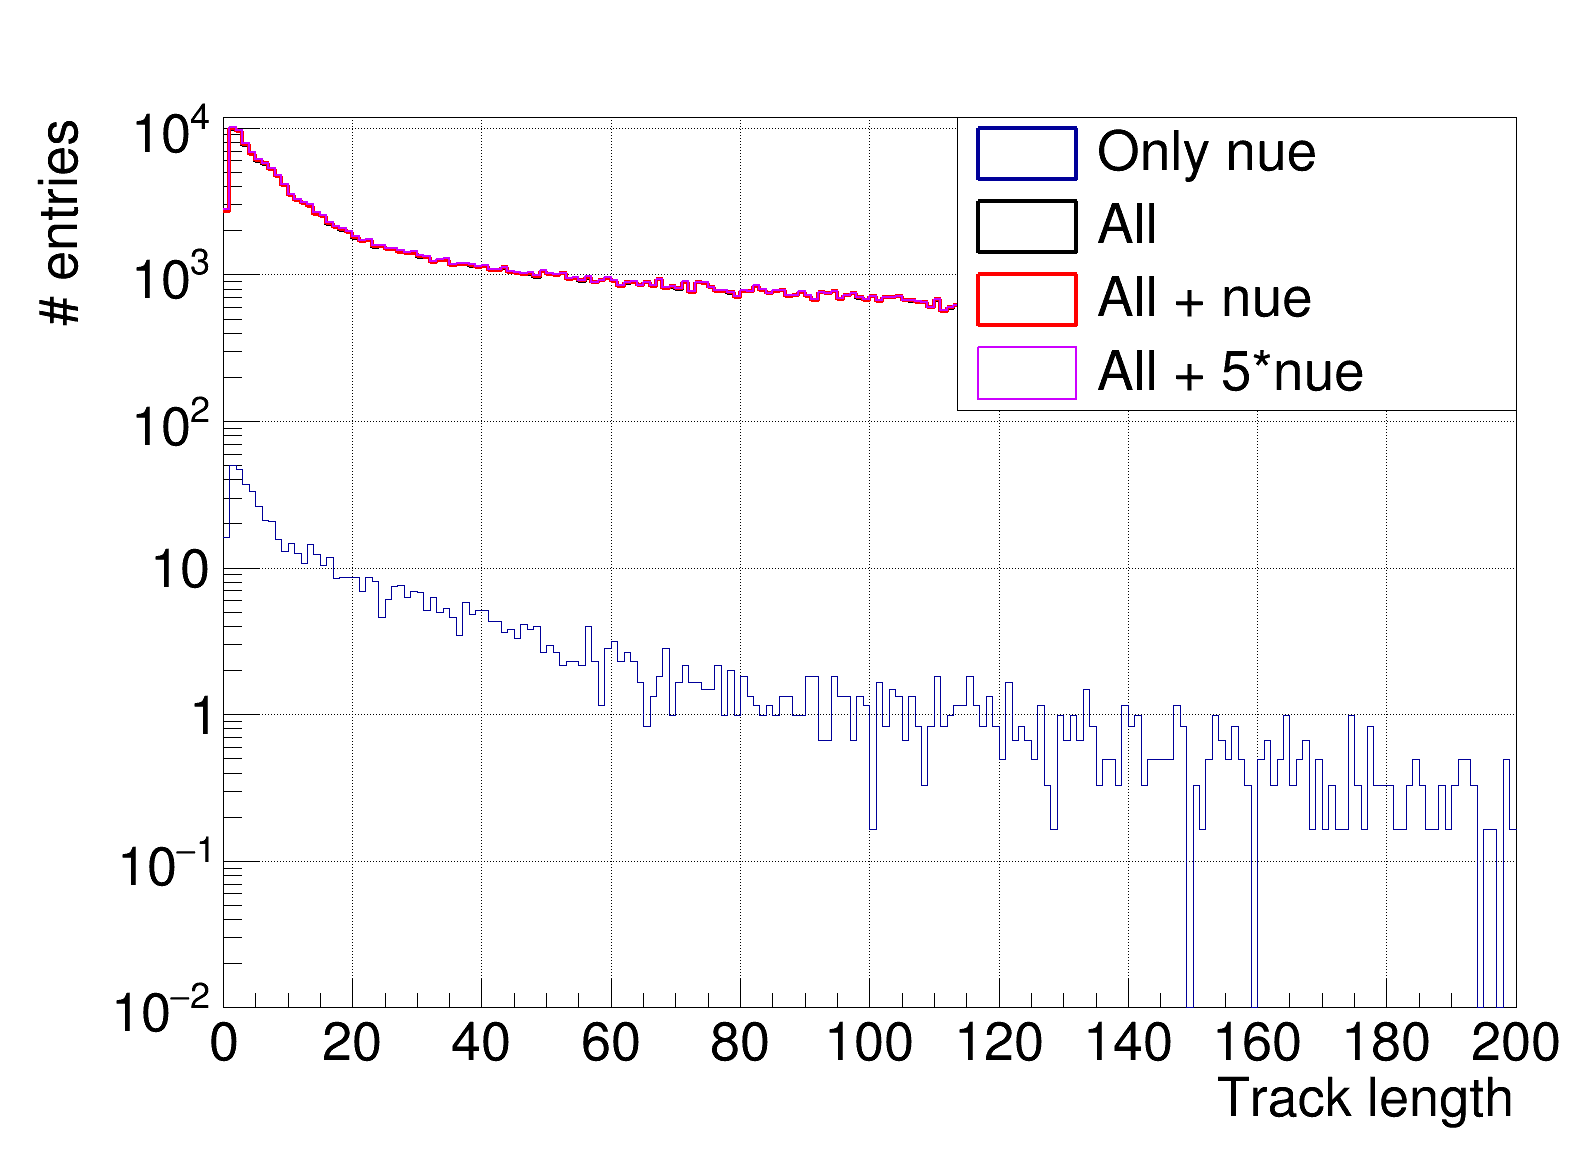

In [88]:
xmax = 200
num_bins = 200
h_temp = ROOT.TH1F("h_temp",'h_temp',num_bins,0,xmax)
h_temp1 = ROOT.TH1F("h_temp1",'h_temp1',num_bins,0,xmax)
h_temp2 = ROOT.TH1F("h_temp2",'h_temp2',num_bins,0,xmax)
h_temp3 = ROOT.TH1F("h_temp3",'h_temp3',num_bins,0,xmax)

h_temp4 = ROOT.TH1F("h_temp4",'h_temp4',num_bins,0,xmax)
h_temp5 = ROOT.TH1F("h_temp5",'h_temp5',num_bins,0,xmax)


ROOT.gStyle.SetPaintTextFormat("0.1f");


overlay.Draw('TrackLength'+'>>h_temp','fidVol','')
overlay.Draw('TrackLength'+'>>h_temp2','fidVol && MCNu_PDG==12','')
#overlay.Draw('TrackLength'+'>>h_temp3','fidVol && MCNu_PDG==12 && MCNu_Energy<1.5 && MCNu_Energy>0.05 && MCfidVol && MCle_PDG==11 && \
#                        MCTrackPDG==11 && sqrt(pow(MCle_Endx-MCTrackEnd_x,2)+pow(MCle_Endy-MCTrackEnd_y,2))<0.1 &&\
#                        MCTrackPurity>0.5')*scale

ext.Draw('TrackLength'+'>>h_temp1','fidVol','')

h_temp.Scale(scale)
h_temp2.Scale(scale)
#h_temp3.Scale(scale)
h_temp1.Scale(scale_ext)
num_track_tot = h_temp1.GetEntries()
print num_track_tot

h_temp1.Add(h_temp)

num_track_tot_ov = h_temp.GetEntries()
num_track_tot_nc = h_temp2.GetEntries()
#num_track_tot_nue_m = h_temp3.GetEntries()
h_temp3 = h_temp2.Clone()
h_temp2.Add(h_temp1)
#h_temp2.Add(h_temp3)

h_temp4 = h_temp2.Clone()
h_temp4.Add(h_temp3)
h_temp4.Add(h_temp3)
h_temp4.Add(h_temp3)
h_temp4.Add(h_temp3)

#h_temp5 = h_temp4.Clone()
#h_temp5.Add(h_temp3)

print 'tot tracks (ov+ext): ',num_track_tot*scale_ext + num_track_tot_ov*scale
print 'tot tracks (ov+ext+2*NC): ',num_track_tot*scale_ext + num_track_tot_ov*scale + num_track_tot_nc*scale

for i in range(num_bins):
    #h_temp1.SetBinError(i+1,0)
    #h_temp2.SetBinError(i+1,0)
    h_temp1.SetBinError(i+1,math.sqrt(h_temp1.GetBinContent(i+1)))
    h_temp2.SetBinError(i+1,math.sqrt(h_temp1.GetBinContent(i+1)))


h_temp1.SetLineColor(ROOT.kBlack)
#h_temp.SetLineColor(ROOT.kRed)
h_temp2.SetLineColor(ROOT.kRed)
h_temp4.SetLineColor(ROOT.kViolet)
h_temp.SetLineWidth(4)
h_temp1.SetLineWidth(4)
h_temp2.SetLineWidth(4)
h_temp.SetLineWidth(4)
h_temp4.SetLineWidth(2)
#h_temp5.SetLineWidth(4)

legend = ROOT.TLegend(0.6,0.65,0.95,0.9)
legend.AddEntry(h_temp,'Only nue',"f")
legend.AddEntry(h_temp1,'All',"f")
legend.AddEntry(h_temp2,'All + nue',"f")
legend.AddEntry(h_temp4,'All + 5*nue',"f")
#legend.AddEntry(h_temp3,'True nue + matched e',"f")
#legend.AddEntry(h_temp4,'Overlay (+matched e)',"f")
#legend.AddEntry(h_temp5,'all',"f")

h_temp1.SetXTitle("Track length")
h_temp1.SetYTitle("# entries")
h_temp1.GetYaxis().SetTitleSize(0.05)
h_temp1.GetYaxis().SetTitleOffset(1.3)
h_temp1.GetYaxis().SetLabelSize(0.05)
h_temp1.GetXaxis().SetTitleSize(0.05)
h_temp1.GetXaxis().SetLabelSize(0.05)
h_temp1.GetXaxis().SetTitleOffset(1)

h_temp1.SetMinimum(0.01)
h_temp1.SetMaximum(h_temp2.GetMaximum()*1.2)
h_temp1.Draw('hist')
#h_temp.Draw('same hist')
h_temp2.Draw('same hist')
h_temp3.Draw('same hist')
h_temp4.Draw('same hist')

#h_temp5.Draw('same hist')


legend.Draw()
c1.SetLogy(1)
c1.Draw()
c1.SaveAs(outputdir_png + 'h_tracklength_chi2_nue.png')
#c1.SaveAs(outputdir_root + 'h_xsec_2D_'+str(x_theta)+'.root')
c1.SaveAs(outputdir_pdf + 'h_tracklength_chi2_nue.pdf')

In [89]:
print h_temp1.GetBinContent(20), h_temp1.GetBinError(20), h_temp1.GetBinError(20)*h_temp1.GetBinError(20)
res = np.zeros((1000))
chi2_mc =h_temp1.Chi2Test(h_temp2,"P UU",res)

chi2_mc =h_temp1.Chi2Test(h_temp4,"P UU",res)

#chi2_mc =h_temp1.Chi2Test(h_temp4,"P WW",res)


1935.84436035 43.9982313321 1935.84436035
Chi2 = 0.264146, Prob = 1, NDF = 199, igood = 0
Chi2 = 6.484350, Prob = 1, NDF = 199, igood = 0


Warning in <TFile::Append>: Replacing existing TH1: h_temp (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: h_temp1 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: h_temp2 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: h_temp3 (Potential memory leak).


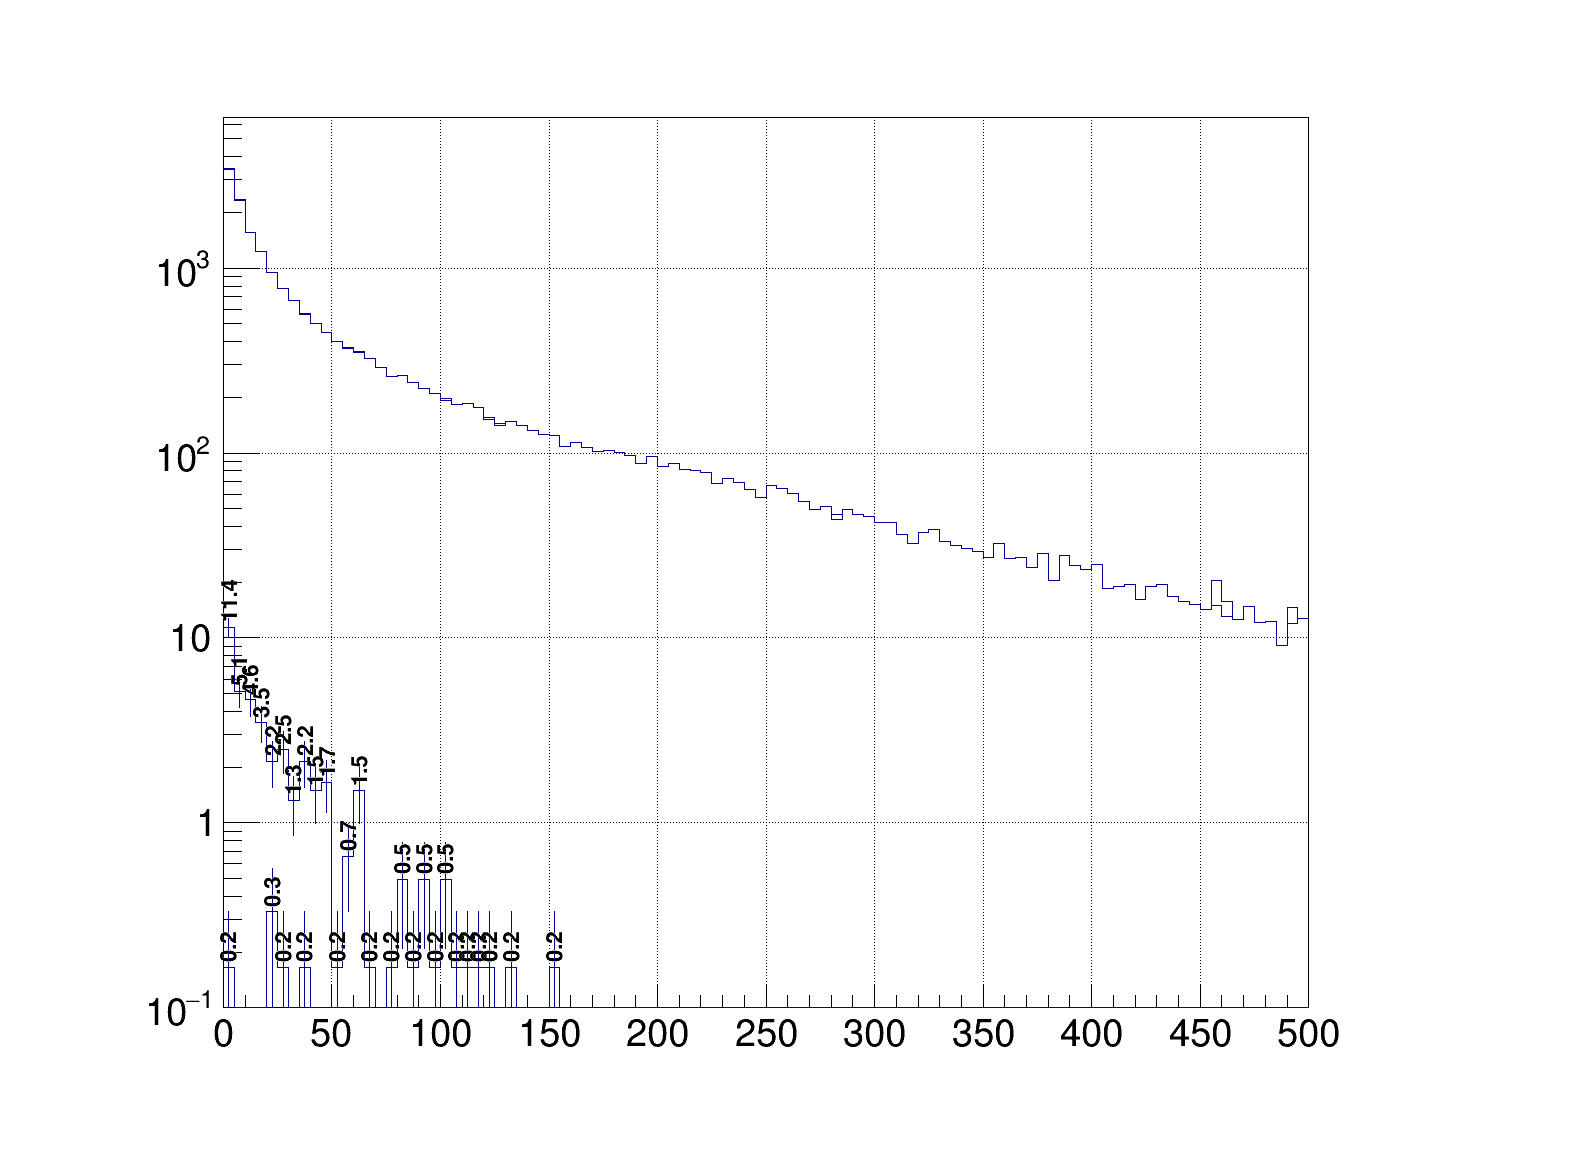

In [44]:
h_temp = ROOT.TH1F("h_temp",'h_temp',100,0,500)
h_temp1 = ROOT.TH1F("h_temp1",'h_temp1',100,0,500)
h_temp2 = ROOT.TH1F("h_temp2",'h_temp2',100,0,500)
h_temp3 = ROOT.TH1F("h_temp3",'h_temp3',100,0,500)

ROOT.gStyle.SetPaintTextFormat("0.1f");


overlay.Draw('TrackLength'+'>>h_temp','fidVol && NuScore>0.99','')
overlay.Draw('TrackLength'+'>>h_temp2','fidVol && NuScore>0.99 && MCNu_PDG==12 && MCNu_Energy<1.5 && MCNu_Energy>0.05 && MCfidVol && MCNu_CCNC==0','')
overlay.Draw('TrackLength'+'>>h_temp3','fidVol && NuScore>0.99 && MCNu_PDG==12 && MCNu_Energy<1.5 && MCNu_Energy>0.05 && MCfidVol && MCle_PDG==11 && \
                        MCTrackPDG==11 && sqrt(pow(MCle_Endx-MCTrackEnd_x,2)+pow(MCle_Endy-MCTrackEnd_y,2))<0.1 &&\
                        MCTrackPurity>0.5')*scale

ext.Draw('TrackLength'+'>>h_temp1','fidVol && NuScore>0.99','')

h_temp.Scale(scale)
h_temp2.Scale(scale)
h_temp3.Scale(scale)
h_temp1.Scale(scale_ext)

h_temp1.Add(h_temp)
h_temp1.SetMinimum(0.1)
h_temp1.Draw('hist')
h_temp.Draw('same hist')
h_temp2.Draw('same hit text')
h_temp3.Draw('same hit text')
c1.SetLogy()
c1.Draw()

In [25]:
#tree_feb = data_up.pandas.df(cols) # read in the TTree file as a pandas
#print 'Number of entries: ',data_up.numentries # print the number of entries
#print([c.decode('UTF-8') for c in data_up.keys()])
#print 'First entry variables: '
#for element in cols:
#    print '%15s :\t'%element,tree_feb[element][600]

In [9]:
overlay.Draw('MCTrackPurity'+'>>h_temp1','MCfidVol && MCNu_PDG==12 && MCNu_Energy<1.5 && MCNu_Energy>0.05 && MCTrackPDG==11','')
dsfdsaf

NameError: name 'dsfdsaf' is not defined

Entries 1490.0
1486
5.45087493956


Info in <TCanvas::SaveAs>: ROOT file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted_improved/nue_check_2/root/h_purity_allTracks.root has been created
Info in <TCanvas::Print>: png file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted_improved/nue_check_2/png/h_purity_allTracks.png has been created
Info in <TCanvas::Print>: pdf file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted_improved/nue_check_2/pdf/h_purity_allTracks.pdf has been created
Info in <TCanvas::SaveAs>: ROOT file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted_improved/nue_check_2/root/h_purity.root has been created
Info in <TCanvas::Print>: png file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted_improved/nue_check_2/png/h_purity.png has been created
Info in <TCanvas::Print>: pdf file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted_improved/nue_check_2/pdf/h_purity.pdf has been created


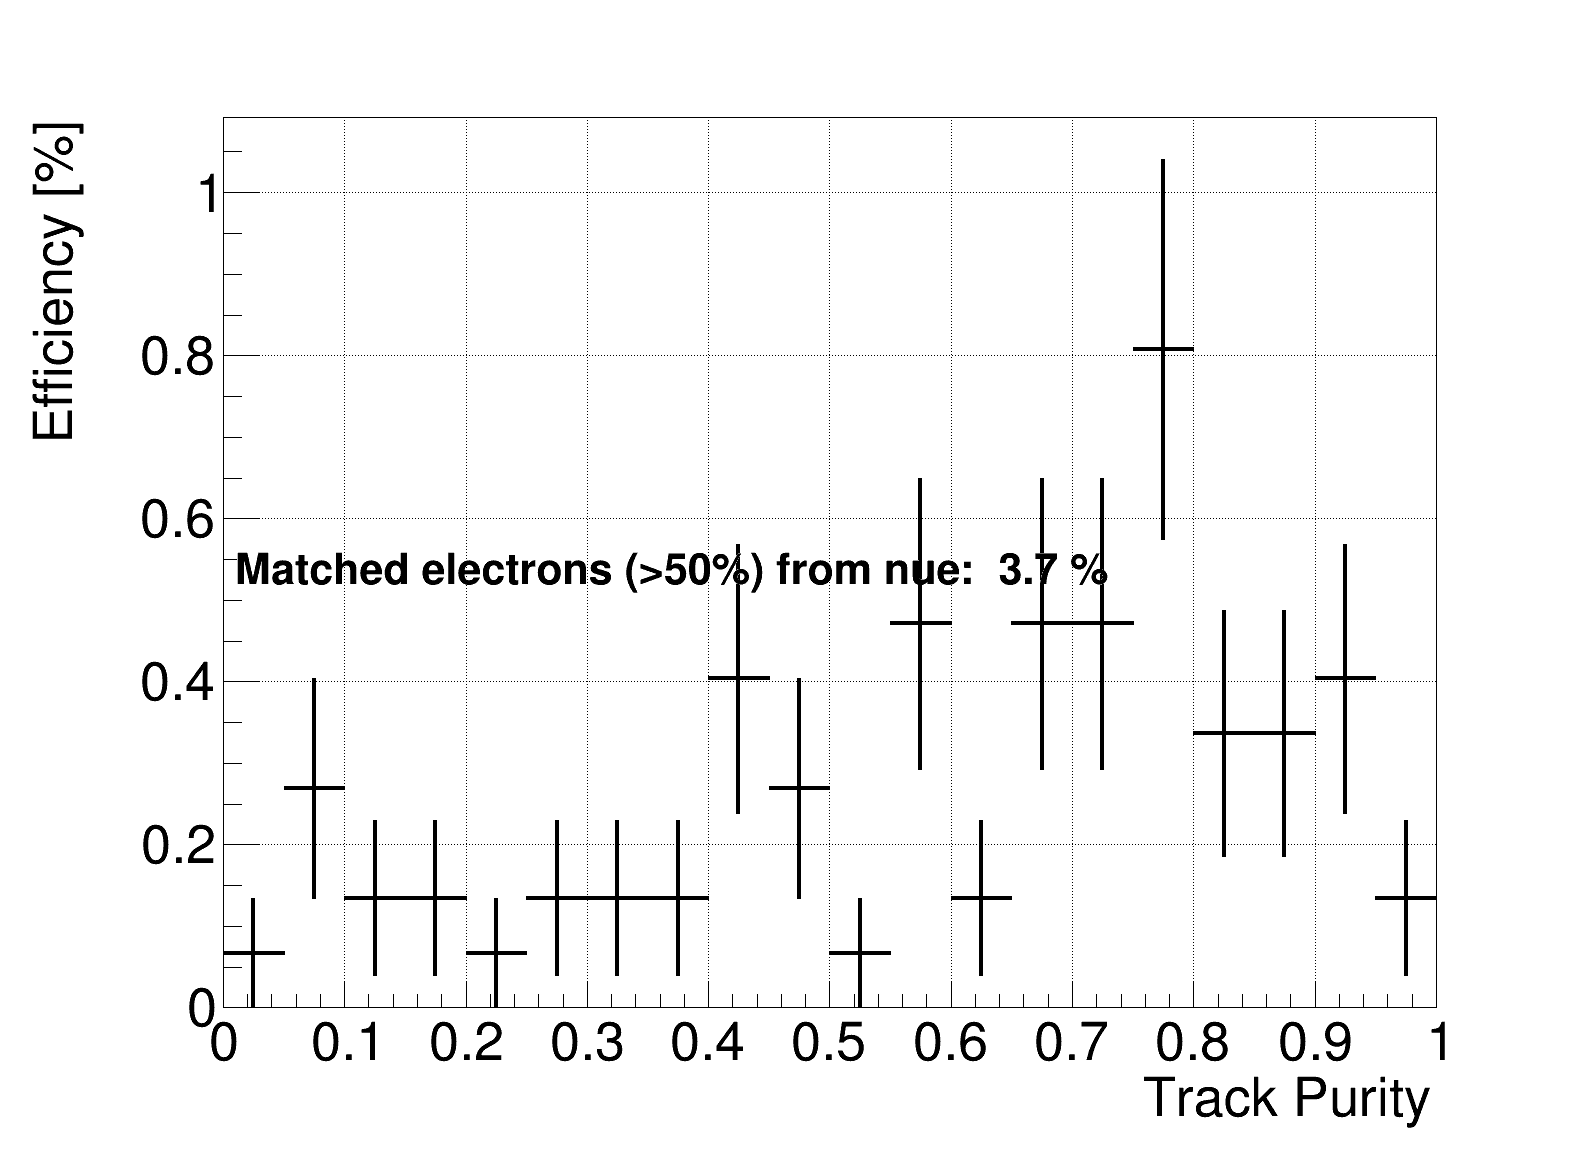

In [10]:
h_temp = ROOT.TH1F("h_temp",'h_temp',200,0,1)
h_temp1 = ROOT.TH1F("h_temp1",'h_temp1',200,0,1)
h_temp2 = ROOT.TH1F("h_temp2",'h_temp2',20,0,1)

matching = 'MCle_PDG==11 && MCTrackPDG==11 && sqrt(pow(MCle_Endx-MCTrackEnd_x,2)+pow(MCle_Endy-MCTrackEnd_y,2))<0.1'


overlay.Draw('MCTrackPurity'+'>>h_temp','MCfidVol && MCNu_PDG==12 && MCNu_Energy<1.5 && MCNu_Energy>0.05','')
overlay.Draw('MCTrackPurity'+'>>h_temp1','MCfidVol && MCNu_PDG==12 && MCNu_Energy<1.5 && MCNu_Energy>0.05 && MCTrackPDG==11','')

h_temp.SetXTitle("Track Purity (all tracks in nu event)")
h_temp.SetYTitle("# events")
h_temp.GetYaxis().SetTitleSize(0.05)
h_temp.GetYaxis().SetTitleOffset(1.3)
h_temp.GetYaxis().SetLabelSize(0.05)
h_temp.GetXaxis().SetTitleSize(0.05)
h_temp.GetXaxis().SetLabelSize(0.05)
h_temp.GetXaxis().SetTitleOffset(1)
h_temp.SetLineColor(ROOT.kBlack)
h_temp.SetLineWidth(4)
h_temp1.SetLineColor(ROOT.kGreen)
h_temp1.SetLineWidth(4)
ROOT.gStyle.SetEndErrorSize(5)
c1.SetRightMargin(0.1)
h_temp.Scale(scale)
h_temp1.Scale(scale)
h_temp.Draw('')
h_temp1.Draw('same')
prelim = draw_sim()
prelim.Draw()
legend = ROOT.TLegend(0.15,0.65,0.5,0.9)
legend.AddEntry(h_temp,'all nue',"lep");
legend.AddEntry(h_temp1,'matched nue',"lep");
legend.Draw()
print "Entries", h_temp.GetEntries()
#h_migration.Draw("same text")
c1.Draw()
c1.SaveAs(outputdir_root + "h_purity_allTracks.root")
c1.SaveAs(outputdir_png + "h_purity_allTracks.png")
c1.SaveAs(outputdir_pdf + "h_purity_allTracks.pdf")

overlay.Draw('MCTrackPurity'+'>>h_temp2','MCfidVol && MCNu_PDG==12 && MCNu_Energy<1.5 && MCNu_Energy>0.05 &&'+matching,'')
nue_tot_rate = overlay_out.GetEntries('MCfidVol && MCNu_PDG==12 && MCNu_Energy<1.5 && MCNu_Energy>0.05')
print nue_tot_rate
h_temp2.Scale(100.0/nue_tot_rate)
h_temp2.SetXTitle("Track Purity")
h_temp2.SetYTitle("Efficiency [%]")
h_temp2.GetYaxis().SetTitleSize(0.05)
h_temp2.GetYaxis().SetTitleOffset(1.3)
h_temp2.GetYaxis().SetLabelSize(0.05)
h_temp2.GetXaxis().SetTitleSize(0.05)
h_temp2.GetXaxis().SetLabelSize(0.05)
h_temp2.GetXaxis().SetTitleOffset(1)
h_temp2.SetLineColor(ROOT.kBlack)
h_temp2.SetLineWidth(4)
t = ROOT.TLatex(0.01,0.52,'Matched electrons (>50%) from nue: \n {:01.1f} %'.format(h_temp2.Integral(11,21)));
t.SetTextFont(62);
t.SetTextSize(1/25.);

h_temp2.Draw()
t.Draw();
print h_temp2.Integral(0,21)
c1.Draw()
c1.SaveAs(outputdir_root + "h_purity.root")
c1.SaveAs(outputdir_png + "h_purity.png")
c1.SaveAs(outputdir_pdf + "h_purity.pdf")

Entries 1211.0
5.74121682346


Warning in <TFile::Append>: Replacing existing TH1: h_temp (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: h_temp1 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: h_temp2 (Potential memory leak).
Info in <TCanvas::SaveAs>: ROOT file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted_improved/nue_check_2/root/h_purity_allTracks.root has been created
Info in <TCanvas::Print>: png file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted_improved/nue_check_2/png/h_purity_allTracks.png has been created
Info in <TCanvas::Print>: pdf file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted_improved/nue_check_2/pdf/h_purity_allTracks.pdf has been created
Info in <TCanvas::SaveAs>: ROOT file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted_improved/nue_check_2/root/h_purity.root has been created
Info in <TCanvas::Print>: png file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted_improved/nue_check_2/pn

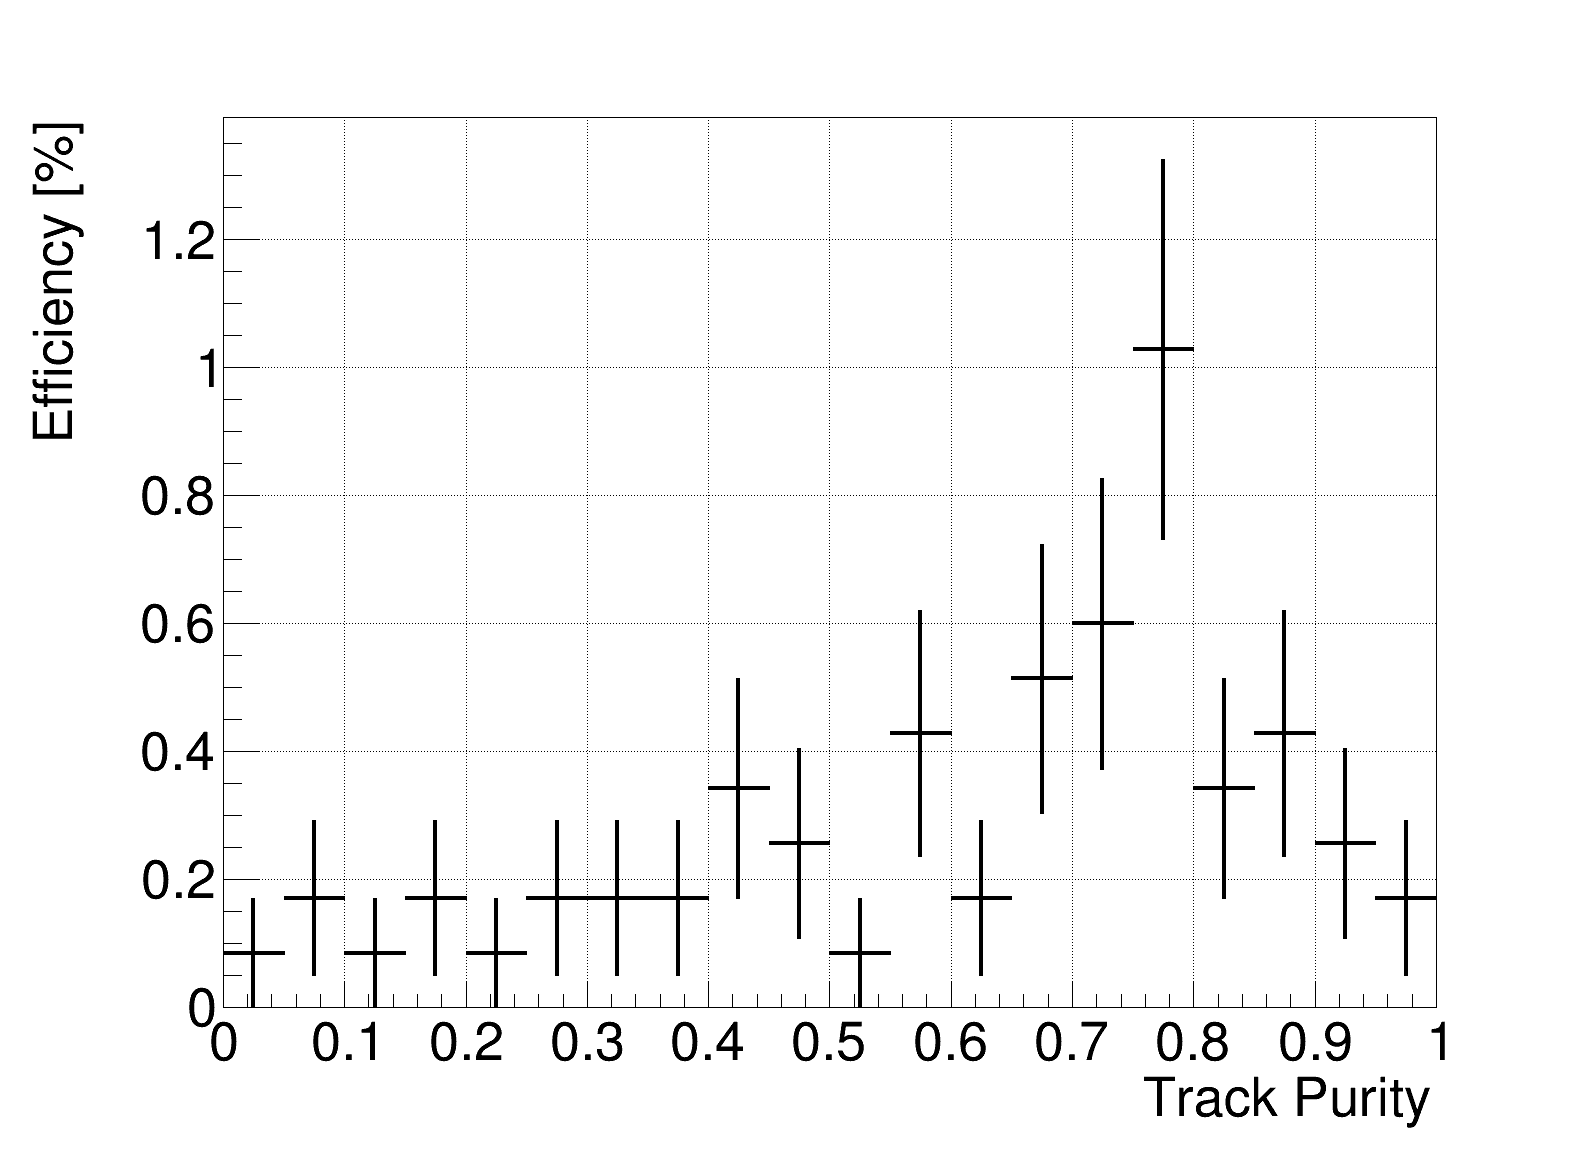

In [15]:
h_temp = ROOT.TH1F("h_temp",'h_temp',200,0,1)
h_temp1 = ROOT.TH1F("h_temp1",'h_temp1',200,0,1)
h_temp2 = ROOT.TH1F("h_temp2",'h_temp2',20,0,1)
cut = 'MCfidVol && MCNu_PDG==12 && MCNu_Energy<1.5 && MCNu_Energy>0.05'
overlay.Draw('MCTrackPurity'+'>>h_temp',cut,'')
overlay.Draw('MCTrackPurity'+'>>h_temp1',cut+' && MCTrackPDG==11 && '+matching,'')

h_temp.SetXTitle("Track Purity (all tracks in nu event)")
h_temp.SetYTitle("# events")
h_temp.GetYaxis().SetTitleSize(0.05)
h_temp.GetYaxis().SetTitleOffset(1.3)
h_temp.GetYaxis().SetLabelSize(0.05)
h_temp.GetXaxis().SetTitleSize(0.05)
h_temp.GetXaxis().SetLabelSize(0.05)
h_temp.GetXaxis().SetTitleOffset(1)
h_temp.SetLineColor(ROOT.kBlack)
h_temp.SetLineWidth(4)
h_temp1.SetLineColor(ROOT.kGreen)
h_temp1.SetLineWidth(4)
ROOT.gStyle.SetEndErrorSize(5)
c1.SetRightMargin(0.1)
h_temp.Draw('')
h_temp1.Draw('same')
prelim = draw_sim()
prelim.Draw()
legend = ROOT.TLegend(0.15,0.65,0.5,0.9)
legend.AddEntry(h_temp,'all nue',"lep");
legend.AddEntry(h_temp1,'matched nue',"lep");
legend.Draw()
print "Entries", h_temp.GetEntries()
#h_migration.Draw("same text")
c1.Draw()
c1.SaveAs(outputdir_root + "h_purity_allTracks.root")
c1.SaveAs(outputdir_png + "h_purity_allTracks.png")
c1.SaveAs(outputdir_pdf + "h_purity_allTracks.pdf")

overlay.Draw('MCTrackPurity'+'>>h_temp2','MCfidVol && MCNu_PDG==12 && MCNu_Energy<1.5 && MCNu_Energy>0.05 && '+matching,'')
nue_tot_rate = overlay_out.GetEntries('MCfidVol && MCNu_PDG==12 && MCNu_Energy<1.5 && MCNu_Energy>0.05')
h_temp2.Scale(100.0/nue_tot_rate)
h_temp2.SetXTitle("Track Purity")
h_temp2.SetYTitle("Efficiency [%]")
h_temp2.GetYaxis().SetTitleSize(0.05)
h_temp2.GetYaxis().SetTitleOffset(1.3)
h_temp2.GetYaxis().SetLabelSize(0.05)
h_temp2.GetXaxis().SetTitleSize(0.05)
h_temp2.GetXaxis().SetLabelSize(0.05)
h_temp2.GetXaxis().SetTitleOffset(1)
h_temp2.SetLineColor(ROOT.kBlack)
h_temp2.SetLineWidth(4)
t = ROOT.TLatex(0.1,4,'Matched electrons (>50%) from nue: \n {:04.1f} %'.format(h_temp2.Integral(10,20)));
t.SetTextFont(62);
t.SetTextSize(1/25.);

h_temp2.Draw()
t.Draw();
print h_temp2.Integral(0,20)
c1.Draw()
c1.SaveAs(outputdir_root + "h_purity.root")
c1.SaveAs(outputdir_png + "h_purity.png")
c1.SaveAs(outputdir_pdf + "h_purity.pdf")

MCfidVol && MCNu_PDG==12 && MCNu_Energy<1.5 && MCNu_Energy>0.05


1784

Info in <TCanvas::SaveAs>: ROOT file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted_improved/nue_check_2/root/h2_true_Momentum.root has been created
Info in <TCanvas::Print>: png file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted_improved/nue_check_2/png/h2_true_Momentum.png has been created
Info in <TCanvas::Print>: pdf file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted_improved/nue_check_2/pdf/h2_true_Momentum.pdf has been created


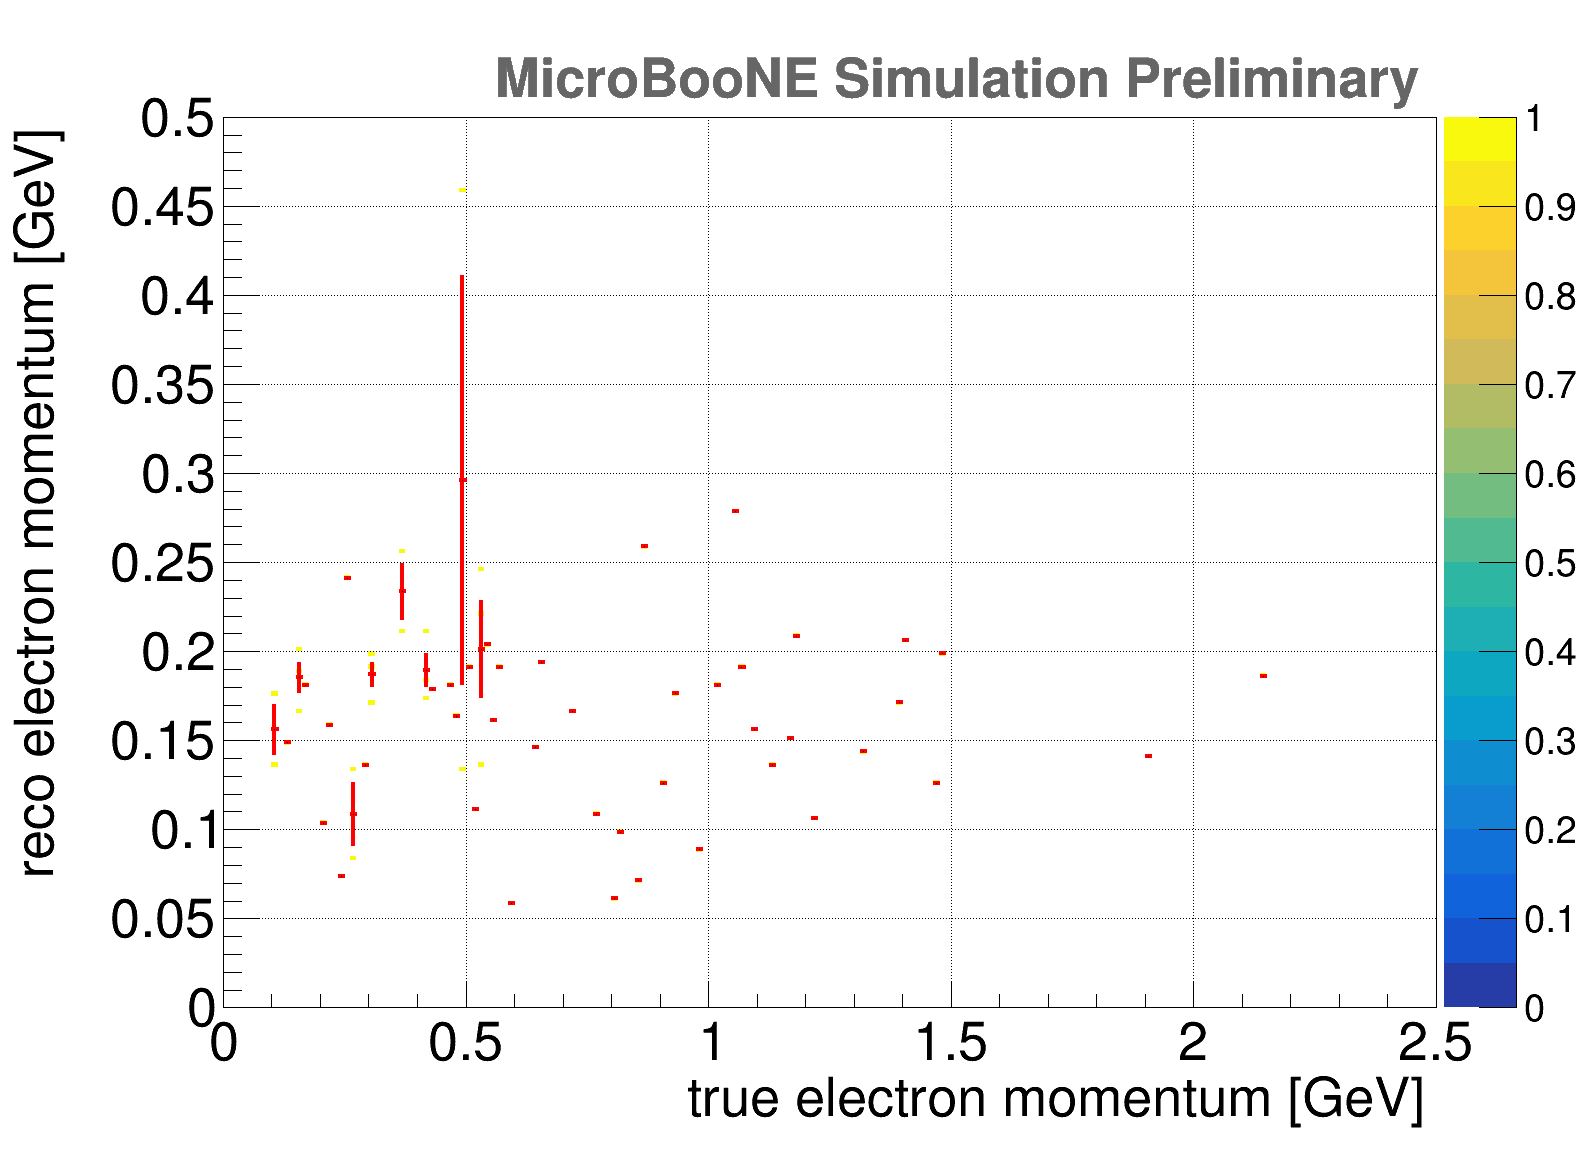

In [16]:
h_migration = ROOT.TH2F("h_migration",'Truth vs. Reco',200,0,2.5,200,0,0.5)
h_migration_r = ROOT.TH2F("h_migration_r",'Truth vs. Reco',200,0,2.5,200,0,0.5)
print cut
cut = 'MCfidVol && MCNu_PDG==12 && MCTrackPDG==11 && MCTrackPurity>0.5 &&'+matching
overlay.Draw('TrackMomMCS_mom:MCle_Energy'+'>>h_migration',cut+' && track_end_uncontained','')
overlay.Draw('TrackMomRange_mu:MCle_Energy'+'>>h_migration_r',cut+'&& !track_end_uncontained','')
h_migration.Add(h_migration_r)
h_migration.SetXTitle("true electron momentum [GeV]")
h_migration.SetYTitle("reco electron momentum [GeV]")
h_migration.GetYaxis().SetTitleSize(0.05)
h_migration.GetYaxis().SetTitleOffset(0.0)
h_migration.GetYaxis().SetLabelSize(0.05)
h_migration.GetXaxis().SetTitleSize(0.05)
h_migration.GetXaxis().SetLabelSize(0.05)
h_migration.GetXaxis().SetTitleOffset(1)
h_migration.SetLineColor(ROOT.kBlack)
h_migration.SetLineWidth(4)
ROOT.gStyle.SetEndErrorSize(5)
c1.SetRightMargin(0.1)
h_migration.Draw("colz")
h_prof = h_migration.ProfileX()
h_prof.SetLineWidth(4)
h_prof.SetLineColor(ROOT.kRed)
h_prof.Draw('same profz')
#h_prof2 = h_migration.ProfileY()
#h_prof2.SetLineWidth(4)
#h_prof2.SetLineColor(ROOT.kOrange)
#h_prof2.Draw('same profz')
prelim = draw_sim()
prelim.Draw()
#h_migration.Draw("same text")
c1.Draw()
c1.SaveAs(outputdir_root + "h2_true_Momentum.root")
c1.SaveAs(outputdir_png + "h2_true_Momentum.png")
c1.SaveAs(outputdir_pdf + "h2_true_Momentum.pdf")
h_migration.Write("h2_true_MCS_fine")

In [ ]:
h_migration = ROOT.TH2F("h_migration",'Truth vs. Reco',200,0,2.5,200,0,2.5)
#h_migration_r = ROOT.TH2F("h_migration_r",'Truth vs. Reco',200,0,2.5,200,0,0.5)
print cut
cut = 'MCfidVol && MCNu_PDG==12 && MCTrackPDG==11 && MCTrackPurity>0.5 &&'+matching
overlay.Draw('TrackMomMCS_mom:MCTrackMomentum'+'>>h_migration',cut,'')
#overlay_out.Draw('TrackMomRange_mu:MCle_Energy'+'>>h_migration_r',cut+'&& !track_end_uncontained','')
#h_migration.Add(h_migration_r)
h_migration.SetXTitle("true electron momentum [GeV]")
h_migration.SetYTitle("reco electron MCS momentum [GeV]")
h_migration.GetYaxis().SetTitleSize(0.05)
h_migration.GetYaxis().SetTitleOffset(0.0)
h_migration.GetYaxis().SetLabelSize(0.05)
h_migration.GetXaxis().SetTitleSize(0.05)
h_migration.GetXaxis().SetLabelSize(0.05)
h_migration.GetXaxis().SetTitleOffset(1)
h_migration.SetLineColor(ROOT.kBlack)
h_migration.SetLineWidth(4)
ROOT.gStyle.SetEndErrorSize(5)
c1.SetRightMargin(0.1)
h_migration.Draw("colz")
h_prof = h_migration.ProfileX()
h_prof.SetLineWidth(4)
h_prof.SetLineColor(ROOT.kRed)
h_prof.Draw('same profz')
prelim = draw_sim()
prelim.Draw()
#h_migration.Draw("same text")
c1.Draw()
c1.SaveAs(outputdir_root + "h2_true_MCS.root")
c1.SaveAs(outputdir_png + "h2_true_MCS.png")
c1.SaveAs(outputdir_pdf + "h2_true_MCS.pdf")
h_migration.Write("h2_true_MCS_fine")

In [ ]:
h_migration = ROOT.TH2F("h_migration",'Truth vs. Reco',200,0,2.5,200,0,2.5)
#h_migration_r = ROOT.TH2F("h_migration_r",'Truth vs. Reco',200,0,2.5,200,0,0.5)
print cut
cut = 'MCfidVol && MCNu_PDG==12 && MCTrackPDG==11 && MCTrackPurity>0.5 &&'+matching
overlay.Draw('MCTrackMomentum:TrackMomMCS_mom'+'>>h_migration',cut,'')
#overlay_out.Draw('TrackMomRange_mu:MCle_Energy'+'>>h_migration_r',cut+'&& !track_end_uncontained','')
#h_migration.Add(h_migration_r)
h_migration.SetYTitle("true electron momentum [GeV]")
h_migration.SetXTitle("reco electron MCS momentum [GeV]")
h_migration.GetYaxis().SetTitleSize(0.05)
h_migration.GetYaxis().SetTitleOffset(0.0)
h_migration.GetYaxis().SetLabelSize(0.05)
h_migration.GetXaxis().SetTitleSize(0.05)
h_migration.GetXaxis().SetLabelSize(0.05)
h_migration.GetXaxis().SetTitleOffset(1)
h_migration.SetLineColor(ROOT.kBlack)
h_migration.SetLineWidth(4)
ROOT.gStyle.SetEndErrorSize(5)
c1.SetRightMargin(0.1)
h_migration.Draw("colz")
h_prof = h_migration.ProfileX()
h_prof.SetLineWidth(4)
h_prof.SetLineColor(ROOT.kRed)
h_prof.Draw('same profz')
prelim = draw_sim()
prelim.Draw()
#h_migration.Draw("same text")
c1.Draw()
c1.SaveAs(outputdir_root + "h2_true_MCS.root")
c1.SaveAs(outputdir_png + "h2_true_MCS.png")
c1.SaveAs(outputdir_pdf + "h2_true_MCS.pdf")
h_migration.Write("h2_true_MCS_fine")

In [ ]:
h_migration = ROOT.TH2F("h_migration",'Truth vs. Reco',800,0,2.5,800,0,2.5)
#h_migration_r = ROOT.TH2F("h_migration_r",'Truth vs. Reco',200,0,2.5,200,0,0.5)
print cut
cut = 'MCfidVol && MCNu_PDG==12 && MCTrackPDG==11 && MCTrackPurity>0.5 &&'+matching
overlay.Draw('TrackMomMCS_mom:MCTrackMomentum'+'>>h_migration',cut,'')
#overlay_out.Draw('TrackMomRange_mu:MCle_Energy'+'>>h_migration_r',cut+'&& !track_end_uncontained','')
#h_migration.Add(h_migration_r)
h_migration.SetXTitle("true electron momentum [GeV]")
h_migration.SetYTitle("reco electron MCS momentum [GeV]")
h_migration.GetYaxis().SetTitleSize(0.05)
h_migration.GetYaxis().SetTitleOffset(0.0)
h_migration.GetYaxis().SetLabelSize(0.05)
h_migration.GetXaxis().SetTitleSize(0.05)
h_migration.GetXaxis().SetLabelSize(0.05)
h_migration.GetXaxis().SetTitleOffset(1)
h_migration.SetLineColor(ROOT.kBlack)
h_migration.SetLineWidth(4)
ROOT.gStyle.SetEndErrorSize(5)
c1.SetRightMargin(0.1)
h_migration.GetYaxis().SetRange(0,160)
h_migration.GetXaxis().SetRange(0,160)
h_migration.Draw("colz")
h_prof = h_migration.ProfileX()
h_prof.SetLineWidth(4)
h_prof.SetLineColor(ROOT.kRed)
h_prof.Draw('same profz')
prelim = draw_sim()
prelim.Draw()
#h_migration.Draw("same text")
c1.Draw()
c1.SaveAs(outputdir_root + "h2_true_MCS_zoom.root")
c1.SaveAs(outputdir_png + "h2_true_MCS_zoom.png")
c1.SaveAs(outputdir_pdf + "h2_true_MCS_zoom.pdf")
h_migration.Write("h2_true_MCS_fine")

In [ ]:
h_migration = ROOT.TH2F("h_migration",'Truth vs. Reco',200,0,2.5,200,0,0.5)
#h_migration_r = ROOT.TH2F("h_migration_r",'Truth vs. Reco',200,0,2.5,200,0,0.5)
print cut
cut = 'MCfidVol && MCNu_PDG==12 && MCTrackPDG==11 && MCTrackPurity>0.5 &&'+matching
overlay.Draw('TrackMomRange_mu:MCTrackMomentum'+'>>h_migration',cut,'')
#overlay_out.Draw('TrackMomRange_mu:MCle_Energy'+'>>h_migration_r',cut+'&& !track_end_uncontained','')
#h_migration.Add(h_migration_r)
h_migration.SetXTitle("true electron momentum [GeV]")
h_migration.SetYTitle("reco electron momentum [GeV]")
h_migration.GetYaxis().SetTitleSize(0.05)
h_migration.GetYaxis().SetTitleOffset(0.0)
h_migration.GetYaxis().SetLabelSize(0.05)
h_migration.GetXaxis().SetTitleSize(0.05)
h_migration.GetXaxis().SetLabelSize(0.05)
h_migration.GetXaxis().SetTitleOffset(1)
h_migration.SetLineColor(ROOT.kBlack)
h_migration.SetLineWidth(4)
ROOT.gStyle.SetEndErrorSize(5)
c1.SetRightMargin(0.1)
h_migration.Draw("colz")
h_prof = h_migration.ProfileX()
h_prof.SetLineWidth(4)
h_prof.SetLineColor(ROOT.kRed)
h_prof.Draw('same profz')
prelim = draw_sim()
prelim.Draw()
#h_migration.Draw("same text")
c1.Draw()
c1.SaveAs(outputdir_root + "h2_true_range.root")
c1.SaveAs(outputdir_png + "h2_true_range.png")
c1.SaveAs(outputdir_pdf + "h2_true_range.pdf")
h_migration.Write("h2_true_MCS_fine")

In [ ]:
h_migration = ROOT.TH2F("h_migration",'Truth vs. Reco',200,0,0.5,200,0,0.5)
#h_migration_r = ROOT.TH2F("h_migration_r",'Truth vs. Reco',200,0,2.5,200,0,0.5)
print cut
cut = 'MCfidVol && MCNu_PDG==12 && MCTrackPDG==11 && MCTrackPurity>0.5 &&'+matching
overlay.Draw('TrackMomRange_mu:MCTrackMomentum'+'>>h_migration',cut,'')
#overlay_out.Draw('TrackMomRange_mu:MCle_Energy'+'>>h_migration_r',cut+'&& !track_end_uncontained','')
#h_migration.Add(h_migration_r)
h_migration.SetXTitle("true electron momentum [GeV]")
h_migration.SetYTitle("reco electron momentum [GeV]")
h_migration.GetYaxis().SetTitleSize(0.05)
h_migration.GetYaxis().SetTitleOffset(0.0)
h_migration.GetYaxis().SetLabelSize(0.05)
h_migration.GetXaxis().SetTitleSize(0.05)
h_migration.GetXaxis().SetLabelSize(0.05)
h_migration.GetXaxis().SetTitleOffset(1)
h_migration.SetLineColor(ROOT.kBlack)
h_migration.SetLineWidth(4)
ROOT.gStyle.SetEndErrorSize(5)
c1.SetRightMargin(0.1)
h_migration.Draw("colz")
h_prof = h_migration.ProfileX()
h_prof.SetLineWidth(4)
h_prof.SetLineColor(ROOT.kRed)
h_prof.Draw('same profz')
prelim = draw_sim()
prelim.Draw()
#h_migration.Draw("same text")
c1.Draw()
c1.SaveAs(outputdir_root + "h2_true_range_zoom.root")
c1.SaveAs(outputdir_png + "h2_true_range_zoom.png")
c1.SaveAs(outputdir_pdf + "h2_true_range_zoom.pdf")
h_migration.Write("h2_true_MCS_fine")

In [ ]:
h_migration = ROOT.TH2F("h_migration",'Truth vs. Reco',200,-1,1,200,-1,1)
h_migration_r = ROOT.TH2F("h_migration_r",'Truth vs. Reco',200,0,2.5,200,0,0.5)
print cut
cut = 'MCfidVol && MCNu_PDG==12 && MCTrackPDG==11 && MCTrackPurity>0.5 &&'+matching
overlay.Draw('cos(TrackTheta):cos(MCTrackTheta)'+'>>h_migration',cut,'')
#overlay_out.Draw('TrackMomRange_mu:MCle_Energy'+'>>h_migration_r',cut+'&& !track_end_uncontained','')
#h_migration.Add(h_migration_r)
h_migration.SetXTitle("true electron cos(theta)")
h_migration.SetYTitle("reco electron cos(theta)")
h_migration.GetYaxis().SetTitleSize(0.05)
h_migration.GetYaxis().SetTitleOffset(0.0)
h_migration.GetYaxis().SetLabelSize(0.05)
h_migration.GetXaxis().SetTitleSize(0.05)
h_migration.GetXaxis().SetLabelSize(0.05)
h_migration.GetXaxis().SetTitleOffset(1)
h_migration.SetLineColor(ROOT.kBlack)
h_migration.SetLineWidth(4)
ROOT.gStyle.SetEndErrorSize(5)
c1.SetRightMargin(0.1)
h_migration.Draw("colz")
h_prof = h_migration.ProfileX()
h_prof.SetLineWidth(4)
h_prof.SetLineColor(ROOT.kRed)
h_prof.Draw('same profz')
prelim = draw_sim()
prelim.Draw()
#h_migration.Draw("same text")
c1.Draw()
c1.SaveAs(outputdir_root + "h2_true_theta.root")
c1.SaveAs(outputdir_png + "h2_true_theta.png")
c1.SaveAs(outputdir_pdf + "h2_true_theta.pdf")
h_migration.Write("h2_true_MCS_fine")

In [ ]:
h_migration = ROOT.TH2F("h_migration",'Truth vs. Reco',200,-3.15,3.15,200,-3.15,3.15)
h_migration_r = ROOT.TH2F("h_migration_r",'Truth vs. Reco',200,0,2.5,200,0,0.5)
print cut
cut = 'MCfidVol && MCNu_PDG==12 && MCTrackPDG==11 && MCTrackPurity>0.5 &&'+matching
overlay.Draw('TrackPhi:MCTrackPhi'+'>>h_migration',cut,'')
#overlay_out.Draw('TrackMomRange_mu:MCle_Energy'+'>>h_migration_r',cut+'&& !track_end_uncontained','')
#h_migration.Add(h_migration_r)
h_migration.SetXTitle("true electron phi")
h_migration.SetYTitle("reco electron phi")
h_migration.GetYaxis().SetTitleSize(0.05)
h_migration.GetYaxis().SetTitleOffset(0.0)
h_migration.GetYaxis().SetLabelSize(0.05)
h_migration.GetXaxis().SetTitleSize(0.05)
h_migration.GetXaxis().SetLabelSize(0.05)
h_migration.GetXaxis().SetTitleOffset(1)
h_migration.SetLineColor(ROOT.kBlack)
h_migration.SetLineWidth(4)
ROOT.gStyle.SetEndErrorSize(5)
c1.SetRightMargin(0.1)
h_migration.Draw("colz")
h_prof = h_migration.ProfileX()
h_prof.SetLineWidth(4)
h_prof.SetLineColor(ROOT.kRed)
h_prof.Draw('same profz')
prelim = draw_sim()
prelim.Draw()
#h_migration.Draw("same text")
c1.Draw()
c1.SaveAs(outputdir_root + "h2_true_phi.root")
c1.SaveAs(outputdir_png + "h2_true_phi.png")
c1.SaveAs(outputdir_pdf + "h2_true_phi.pdf")
h_migration.Write("h2_true_MCS_fine")

In [ ]:
h_migration = ROOT.TH2F("h_migration",'Truth vs. Reco',200,0,100,200,0,100)
h_migration_r = ROOT.TH2F("h_migration_r",'Truth vs. Reco',200,0,2.5,200,0,0.5)
print cut
cut = 'MCfidVol &&MCNu_CCNC==0 && MCNu_PDG==12 && MCTrackPDG==11 && MCTrackPurity>0.5 &&'+matching
overlay.Draw('TrackLength:MCTrackLength'+'>>h_migration',cut,'')
#overlay_out.Draw('TrackMomRange_mu:MCle_Energy'+'>>h_migration_r',cut+'&& !track_end_uncontained','')
#h_migration.Add(h_migration_r)
h_migration.SetXTitle("true electron length [cm]")
h_migration.SetYTitle("reco electron length [cm]")
h_migration.GetYaxis().SetTitleSize(0.05)
h_migration.GetYaxis().SetTitleOffset(0.0)
h_migration.GetYaxis().SetLabelSize(0.05)
h_migration.GetXaxis().SetTitleSize(0.05)
h_migration.GetXaxis().SetLabelSize(0.05)
h_migration.GetXaxis().SetTitleOffset(1)
h_migration.SetLineColor(ROOT.kBlack)
h_migration.SetLineWidth(4)
ROOT.gStyle.SetEndErrorSize(5)
c1.SetRightMargin(0.1)
h_migration.Draw("colz")
h_prof = h_migration.ProfileX()
h_prof.SetLineWidth(4)
h_prof.SetLineColor(ROOT.kRed)
h_prof.Draw('same profz')
prelim = draw_sim()
prelim.Draw()
#h_migration.Draw("same text")
c1.Draw()
c1.SaveAs(outputdir_root + "h2_true_length.root")
c1.SaveAs(outputdir_png + "h2_true_length.png")
c1.SaveAs(outputdir_pdf + "h2_true_length.pdf")
h_migration.Write("h2_true_MCS_fine")

MCfidVol &&MCNu_CCNC==0 && MCNu_PDG==12 && MCTrackPDG==11 && MCTrackPurity>0.5 &&MCle_PDG==11 && MCTrackPDG==11 && sqrt(pow(MCle_Endx-MCTrackEnd_x,2)+pow(MCle_Endy-MCTrackEnd_y,2))<0.1


678

Warning in <TFile::Append>: Replacing existing TH1: h_migration (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: h_migration_all (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: h_migration_matched (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: h_migration_noCosmic (Potential memory leak).
Info in <TCanvas::SaveAs>: ROOT file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted_improved/nue_check_2/root/h2_true_length.root has been created
Info in <TCanvas::Print>: png file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted_improved/nue_check_2/png/h2_true_length.png has been created
Info in <TCanvas::Print>: pdf file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted_improved/nue_check_2/pdf/h2_true_length.pdf has been created


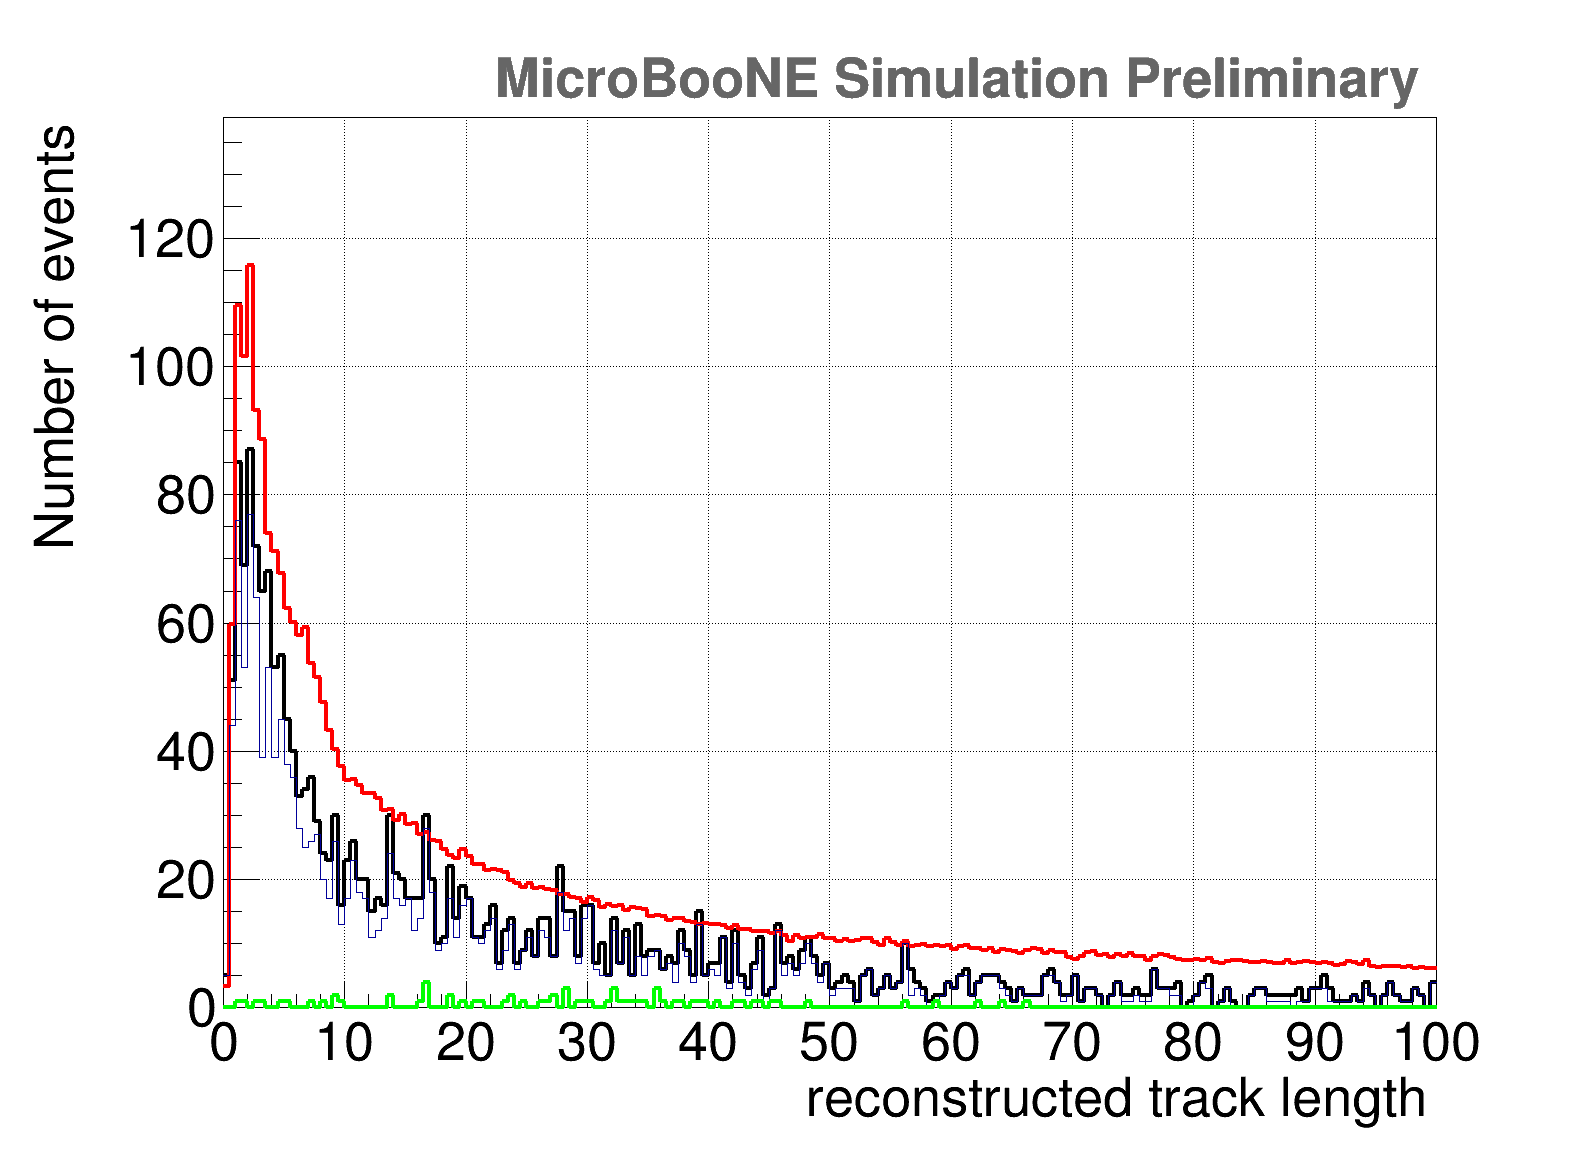

In [28]:
h_migration = ROOT.TH1F("h_migration",'Truth vs. Reco',200,0,100)
h_migration_all = ROOT.TH1F("h_migration_all",'Truth vs. Reco',200,0,100)
h_migration_matched = ROOT.TH1F("h_migration_matched",'Truth vs. Reco',200,0,100)
h_migration_noCosmic = ROOT.TH1F("h_migration_noCosmic",'Truth vs. Reco',200,0,100)

print cut

cut_vertex = 'sqrt(pow(Nu_Vx_sce-MCNu_Vx,2)+pow(Nu_Vy_sce-MCNu_Vy,2)+pow(Nu_Vz_sce-MCNu_Vz,2))<10'
cut = 'MCfidVol &&MCNu_CCNC==0 && MCNu_PDG==12 && MCTrackPDG==11 && MCTrackPurity>0.5 &&'+matching
overlay.Draw('TrackLength'+'>>h_migration_all','MCfidVol &&MCNu_CCNC==0','')
overlay.Draw('TrackLength'+'>>h_migration','MCfidVol &&MCNu_CCNC==0 && MCNu_PDG==12','')
overlay.Draw('TrackLength'+'>>h_migration_noCosmic','MCfidVol && MCNu_CCNC==0 && MCNu_PDG==12 &&'+cut_vertex,'')
overlay.Draw('TrackLength'+'>>h_migration_matched',cut,'')
#overlay_out.Draw('TrackMomRange_mu:MCle_Energy'+'>>h_migration_r',cut+'&& !track_end_uncontained','')
#h_migration.Add(h_migration_r)
h_migration.SetXTitle("reconstructed track length")
h_migration.SetYTitle("Number of events")
h_migration.GetYaxis().SetTitleSize(0.05)
h_migration.GetYaxis().SetTitleOffset(0.0)
h_migration.GetYaxis().SetLabelSize(0.05)
h_migration.GetXaxis().SetTitleSize(0.05)
h_migration.GetXaxis().SetLabelSize(0.05)
h_migration.GetXaxis().SetTitleOffset(1)
h_migration.SetLineColor(ROOT.kBlack)
h_migration.SetLineWidth(4)
ROOT.gStyle.SetEndErrorSize(5)
c1.SetRightMargin(0.1)
h_migration_all.SetLineWidth(4)
h_migration_all.SetLineColor(ROOT.kRed)
h_migration_all.Scale(1.0/100)
h_migration.SetMaximum(h_migration_all.GetMaximum()*1.2)
h_migration.Draw("")
h_migration_all.Draw('hist same')
h_migration_noCosmic.Draw('same')
h_migration_matched.SetLineWidth(4)
h_migration_matched.SetLineColor(ROOT.kGreen)
h_migration_matched.Draw('same')

prelim = draw_sim()
prelim.Draw()
#h_migration.Draw("same text")
c1.Draw()
c1.SaveAs(outputdir_root + "h2_true_length.root")
c1.SaveAs(outputdir_png + "h2_true_length.png")
c1.SaveAs(outputdir_pdf + "h2_true_length.pdf")
h_migration.Write("h2_true_MCS_fine")

In [ ]:
h_migration = ROOT.TH1F("h_migration",'Truth vs. Reco',10,0,10)
h_migration_all = ROOT.TH1F("h_migration_all",'Truth vs. Reco',10,0,10)
print cut
cut = 'MCfidVol &&MCNu_CCNC==0 && MCNu_PDG==12 && MCTrackPDG==11 && MCTrackPurity>0.5 &&'+matching
overlay.Draw('NuTracks'+'>>h_migration_all','MCfidVol &&MCNu_CCNC==0 && MCNu_PDG==12','')
overlay.Draw('NuTracks'+'>>h_migration',cut,'')
#overlay_out.Draw('TrackMomRange_mu:MCle_Energy'+'>>h_migration_r',cut+'&& !track_end_uncontained','')
#h_migration.Add(h_migration_r)
h_migration.SetXTitle("Number of Tracks")
h_migration.SetYTitle("Number of events")
h_migration.GetYaxis().SetTitleSize(0.05)
h_migration.GetYaxis().SetTitleOffset(0.0)
h_migration.GetYaxis().SetLabelSize(0.05)
h_migration.GetXaxis().SetTitleSize(0.05)
h_migration.GetXaxis().SetLabelSize(0.05)
h_migration.GetXaxis().SetTitleOffset(1)
h_migration.SetLineColor(ROOT.kBlack)
h_migration.SetLineWidth(4)
ROOT.gStyle.SetEndErrorSize(5)
c1.SetRightMargin(0.1)
h_migration.SetMaximum(h_migration_all.GetMaximum()*1.2)
h_migration.Draw("")
h_migration_all.Draw('same')
prelim = draw_sim()
prelim.Draw()
#h_migration.Draw("same text")
c1.Draw()
c1.SaveAs(outputdir_root + "h2_true_length.root")
c1.SaveAs(outputdir_png + "h2_true_length.png")
c1.SaveAs(outputdir_pdf + "h2_true_length.pdf")
h_migration.Write("h2_true_MCS_fine")

In [ ]:
h_temp = ROOT.TH2F("h_temp",'h_temp',20,0,1,3,0,2)
overlay_out.Draw('(MCTrackPDG==11):MCTrackPurity'+'>>h_temp','','')
h_temp.SetXTitle("Purity")
h_temp.SetYTitle("is electron from neutrino")
h_temp.GetYaxis().SetTitleSize(0.05)
h_temp.GetYaxis().SetTitleOffset(1.3)
h_temp.GetYaxis().SetLabelSize(0.05)
h_temp.GetXaxis().SetTitleSize(0.05)
h_temp.GetXaxis().SetLabelSize(0.05)
h_temp.GetXaxis().SetTitleOffset(1)
h_temp.SetLineColor(ROOT.kBlack)
h_temp.SetLineWidth(4)
ROOT.gStyle.SetEndErrorSize(5)
c1.SetRightMargin(0.1)
h_temp.Draw('colz text')
prelim = draw_sim()
prelim.Draw()
legend = ROOT.TLegend(0.15,0.65,0.3,0.9)
legend.AddEntry(h_temp,'Nue',"lep");
legend.Draw()
print "Entries", h_temp.GetEntries()
#h_migration.Draw("same text")
c1.Draw()
c1.SaveAs(globale.outputdir_root + "h_temp.root")
c1.SaveAs(globale.outputdir_png + "h_temp.png")
c1.SaveAs(globale.outputdir_pdf + "h_temp.pdf")

In [ ]:
h_migration = ROOT.TH2F("h_migration",'Truth vs. Reco',200,0,2.5,200,0,2.5)
h_migration_r = ROOT.TH2F("h_migration_r",'Truth vs. Reco',200,0,2.5,200,0,2.5)
print cut
overlay_out.Draw('MCle_Energy:TrackMomMCS_mom'+'>>h_migration',cut+' && track_end_uncontained','')
overlay_out.Draw('MCle_Energy:TrackMomRange_mu'+'>>h_migration_r',cut+'&& !track_end_uncontained','')
h_migration.Add(h_migration_r)
h_migration.SetXTitle("reco Muon momentum [GeV]")
h_migration.SetYTitle("true Muon momentum [GeV]")
h_migration.GetYaxis().SetTitleSize(0.05)
h_migration.GetYaxis().SetTitleOffset(0.0)
h_migration.GetYaxis().SetLabelSize(0.05)
h_migration.GetXaxis().SetTitleSize(0.05)
h_migration.GetXaxis().SetLabelSize(0.05)
h_migration.GetXaxis().SetTitleOffset(1)
h_migration.SetLineColor(ROOT.kBlack)
h_migration.SetLineWidth(4)
ROOT.gStyle.SetEndErrorSize(5)
c1.SetRightMargin(0.1)
h_migration.Draw("colz")
prelim = draw_sim()
prelim.Draw()
#h_migration.Draw("same text")
c1.Draw()
c1.SaveAs(globale.outputdir_root + "h2_true_MCS.root")
c1.SaveAs(globale.outputdir_png + "h2_true_MCS.png")
c1.SaveAs(globale.outputdir_pdf + "h2_true_MCS.pdf")
h_migration.Write("h2_true_MCS_fine")

In [ ]:
h_migration = ROOT.TH2F("h_migration",'Truth vs. Reco',200,0,2.5,200,0,2.5)
h_migration_r = ROOT.TH2F("h_migration_r",'Truth vs. Reco',200,0,2.5,200,0,2.5)
print cut
overlay_out.Draw('MCle_Energy:TrackMomMCS_mom'+'>>h_migration',cut+' && track_end_uncontained','')
overlay_out.Draw('MCle_Energy:TrackMomRange_mu'+'>>h_migration_r',cut+'&& !track_end_uncontained','')
h_migration.Add(h_migration_r)
h_migration.SetXTitle("reco Muon momentum [GeV]")
h_migration.SetYTitle("true Muon momentum [GeV]")
h_migration.GetYaxis().SetTitleSize(0.05)
h_migration.GetYaxis().SetTitleOffset(0.0)
h_migration.GetYaxis().SetLabelSize(0.05)
h_migration.GetXaxis().SetTitleSize(0.05)
h_migration.GetXaxis().SetLabelSize(0.05)
h_migration.GetXaxis().SetTitleOffset(1)
h_migration.SetLineColor(ROOT.kBlack)
h_migration.SetLineWidth(4)
ROOT.gStyle.SetEndErrorSize(5)
c1.SetRightMargin(0.1)
h_migration.Draw("colz")
prelim = draw_sim()
prelim.Draw()
#h_migration.Draw("same text")
c1.Draw()
c1.SaveAs(globale.outputdir_root + "h2_true_MCS.root")
c1.SaveAs(globale.outputdir_png + "h2_true_MCS.png")
c1.SaveAs(globale.outputdir_pdf + "h2_true_MCS.pdf")
h_migration.Write("h2_true_MCS_fine")